In [ ]:
from IPython.display import display
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import mpld3
import time
import fiscalyear
import calendar
import datetime
from datetime import date, timedelta, datetime

In [ ]:
mpld3.disable_notebook()
%matplotlib tk

In [2]:
def date_fin_mois(row):
    annee = row['annee_debut'] 
    mois = row['mois_debut']
    jour = calendar.monthrange(row['annee_debut'],row['mois_debut'])[1]
    return datetime.date(annee, mois, jour)

In [3]:
def get_first_day(dt, d_years=0, d_months=0):
    # d_years, d_months are "deltas" to apply to dt
    y, m = dt.year + d_years, dt.month + d_months
    a, m = divmod(m-1, 12)
    return date(y+a, m+1, 1)

def get_last_day(dt):
    return get_first_day(dt, 0, 1) + timedelta(-1)

BD Succursales

In [4]:
df_succursales = pd.read_excel('W:/Notebooks/bd/bd_batiments.xlsx')
df_succursales = df_succursales[df_succursales['longitude']<0.]
df_succursales = df_succursales.set_index('Transit')

In [ ]:
listStation = df_succursales['nearest_station1'].value_counts().index.values.tolist() + \
    df_succursales['nearest_station2'].value_counts().index.values.tolist() + \
    df_succursales['nearest_station3'].value_counts().index.values.tolist() + \
    df_succursales['nearest_station4'].value_counts().index.values.tolist()

listStation = list(set(listStation))

#map(int, listStation)
#print(list(map(int, listStation)))

BD Factures

In [5]:
df_factures = pd.read_excel('W:/Notebooks/bd/bd_factures_BN_05-2012_06-2018.xlsx')
#df_factures = pd.read_excel('W:/Notebooks/bd/bd_factures_BN_11-2005_10-2017.xlsx')
#df_factures = pd.read_excel('/Users/user/Google Drive/SuiviEnergetique/Notebooks/bd/bd_factures_BN_11-2005_10-2017.xlsx')

#df_factures = df_factures.dropna(how='all')
df_factures = df_factures[df_factures.Compteur != 'Compteur']
df_factures = df_factures[df_factures.Fournisseur != 'Autres fournisseurs']
df_factures = df_factures.dropna(axis=0)

df_factures['Transit'] = df_factures['Bâtiment'].apply(lambda y: str(y)[:6])

df_factures['date_fin_ts'] = pd.to_datetime(df_factures['Date fin'], format='%Y-%m-%d')
df_factures['date_debut_ts'] = pd.to_datetime(df_factures['Date début'], format='%Y-%m-%d')

df_factures['date_debut_dt'] = df_factures['Date début']
df_factures['date_fin_dt']=df_factures['Date fin'] 

df_factures['date_fin_fy'] = df_factures['date_fin_ts'].apply(lambda x: fiscalyear.FiscalDateTime.fromtimestamp(time.mktime(x.timetuple())))
df_factures['date_debut_fy'] = df_factures['date_debut_ts'].apply(lambda x: fiscalyear.FiscalDateTime.fromtimestamp(time.mktime(x.timetuple())))

df_factures['annee_fin'] = df_factures['date_fin_dt'].apply(lambda x: x.year)
df_factures['mois_fin'] = df_factures['date_fin_dt'].apply(lambda x: x.month)
df_factures['jour_fin'] = df_factures['date_fin_dt'].apply(lambda x: x.day)

df_factures['annee_debut'] = df_factures['date_debut_dt'].apply(lambda x: x.year)
df_factures['mois_debut'] = df_factures['date_debut_dt'].apply(lambda x: x.month)
df_factures['jour_debut'] = df_factures['date_debut_dt'].apply(lambda x: x.day)

#df_factures['fin_mois_date_debut'] = df_factures.apply(date_fin_mois, axis=1)
#df_factures['fin_mois_date_debut'] = pd.to_datetime(df_factures['fin_mois_date_debut'], format='%Y-%m-%d')
#df_factures['pourcentage_date_debut'] = ( df_factures['fin_mois_date_debut'] - df_factures['Date debut'] ).apply(lambda x: x.total_seconds()) / ( df_factures['Date fin'] - df_factures['Date debut'] ).apply(lambda x: x.total_seconds())

#df_factures['annee_financiere_debut'] = df_factures['Date debut'].apply(lambda x: x.year)
#df_factures['annee_financiere_fin'] = df_factures['Date fin'].apply(lambda x: x.year)

df_factures['Consommation_kWh'] = df_factures['Consommation (kWh)']
df_factures['superficie_m2'] = df_succursales.loc[df_factures['Transit'],'superficie_m2'].values
df_factures['Consommation_kWh/m2'] = df_factures['Consommation_kWh'] / df_factures['superficie_m2'] 

C:\Users\EMaracaja\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


BD Projets

In [6]:
df_projets = pd.read_excel('W:/Notebooks/bd/bd_projets.xlsx')
df_projets = df_projets.set_index(['Transit','Annee','ClasseProjet'])
idx = pd.IndexSlice

In [ ]:
# Période:
start = '2013-01-01'
end = '2017-12-31'

In [7]:
# Supprimer les transits qui ne sont pas sur Mercure

df_factures_transit = df_factures.groupby('Transit').count()
df_succursales_transit = df_succursales['Province']

temp1 = df_factures_transit.index
temp2 = df_succursales_transit.index

temp3 = [item for item in temp1 if item not in temp2]

df_factures = df_factures[~df_factures['Transit'].isin(temp3)]

BD Degrés-jours

In [8]:
df_DJ = pd.read_csv('W:/Notebooks/bd/bd_DJ_succursales.csv')
df_DJ = df_DJ.set_index(['transit','annee','mois'])

-------------------

# Calcul des degrés-jours pour chaque succursale

-------------------

In [ ]:
list_df_DJ = []

for transit in df_succursales.index:
    list_df = []
    listStation = [df_succursales.loc[transit,'nearest_station1'],df_succursales.loc[transit,'nearest_station2'],df_succursales.loc[transit,'nearest_station3']]
    print(transit)
    for station in listStation:
        stationID = int(station)
        print(stationID)
        appended_data = []
        for infile in glob.glob("W:/Notebooks/bd/bd_reader/datastation%s*.csv" % str(stationID)):
            data = pd.read_csv(infile,index_col='Date/Time',skiprows=24)
            # store DataFrame in list
            appended_data.append(data['Mean Temp (°C)'])
        # Concatenate lists of dataframes axis=0 (rows)
        appended_data = pd.concat(appended_data, axis=0)
        list_df.append(appended_data)
    df = pd.concat(list_df, axis=1)
    df = df.fillna(method='bfill',axis=1)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    df.columns.values[0] = 'Temp'

    df['DJ_chauff_18'] = (18. - df['Temp'])
    df['DJ_clim_10'] = (df['Temp']-10.)
    df.loc[df["DJ_chauff_18"] < 0., ["DJ_chauff_18"]] = 0
    df.loc[df["DJ_clim_10"] < 0., ["DJ_clim_10"]] = 0
    df['transit'] = transit
    list_df_DJ.append(df)

Par annee et mois

In [ ]:
df_DJ = pd.concat(list_df_DJ, axis=0)
print(df_DJ.head())
print(len(df_DJ))
df_DJ['Date'] = df_DJ.index
#df_consommation_norm['Date'] = df_consommation_norm['Date'].apply(lambda x: fiscalyear.FiscalDateTime.fromtimestamp(time.mktime(x.timetuple())))
df_DJ['annee'] = df_DJ['Date'].apply(lambda x: x.year)
df_DJ['mois'] = df_DJ['Date'].apply(lambda x: x.month)
df_DJ = df_DJ.drop(['Date'], axis=1)
df_DJ = df_DJ.groupby(['transit','annee','mois']).sum()

df_DJ = df_DJ.drop(['Temp','Mean Temp (°C)','Mean Temp (°C)'], axis=1)
df_DJ.head()

-------------

# DataFrame des Factures

------------------------

Par année et mois

In [9]:
list_df = []
listTransit=df_factures['Transit'].value_counts().index

for transit in listTransit:
    start_date = '1/1/2005'
    end_date = '12/31/2018'
    idx = pd.date_range(start=start_date, end=end_date)
    col=['Consommation_kWh_eq_m2','Consommation_kWh']
    df = pd.DataFrame(0., idx, col)
    df['Date'] = df.index
    #df['Date'] = df['Date'].apply(lambda x: fiscalyear.FiscalDateTime.fromtimestamp(time.mktime(x.timetuple())))
    df['annee'] = df['Date'].apply(lambda x: x.year)
    df['mois'] = df['Date'].apply(lambda x: x.month)
    df = df.drop(['Date'], axis=1)
    df['transit'] = transit
    
    list_df.append(df)

df_final = pd.concat(list_df,axis=0)
df_final = df_final.groupby(['transit','annee','mois']).sum()
#df_final = df_final.set_index(['transit','annee_financiere','quarter'])

-------------

# Allocation des factures

-------------------

Allocation par mois

In [10]:
for idx in df_factures.index:
    date_debut = df_factures.loc[idx]['date_debut_dt']
    date_fin = df_factures.loc[idx]['date_fin_dt'] 
    last_day = datetime.combine(get_last_day(date_debut), datetime.min.time())
    list_intermed = []    
    date_ = date_debut
    transit = df_factures.loc[idx]['Transit']
    print(idx)
    while last_day<date_fin:
        list_intermed.append(last_day)
        date_ = date_ + timedelta(days=31)
        last_day = datetime.combine(get_last_day(date_), datetime.min.time())
        #print(last_day)
    
    list_intermed.insert(0,date_debut)
    list_intermed.insert(len(list_intermed),date_fin)
    list_intermed_mois = [ x.month for x in list_intermed ]
    list_intermed_mois = list(set(list_intermed_mois))
    list_intermed_annee = [ x.year for x in list_intermed ]
    #list_intermed_annee = list(set(list_intermed_annee))
    #list_dates = zip(list_intermed,list_intermed_annee,list_intermed_mois)
    list_pourc = []
    
    for i in range(1,len(list_intermed)):
        if (list_intermed[-1]-list_intermed[0]).total_seconds() ==0.:
            continue
        pourc = (list_intermed[i]-list_intermed[i-1]).total_seconds() / (list_intermed[-1]-list_intermed[0]).total_seconds()
        list_pourc.append(pourc)
    
    list_alloc = list(zip(list_intermed_annee, list_intermed_mois, list_pourc))
    
    for annee, mois, pc in list_alloc:
        print(pc)
        df_final.loc[transit].loc[annee].loc[mois]['Consommation_kWh_eq_m2'] += df_factures.loc[idx]['Consommation_kWh/m2'] * pc
        df_final.loc[transit].loc[annee].loc[mois]['Consommation_kWh'] += df_factures.loc[idx]['Consommation_kWh'] * pc

0
1.0
1
1.0
2
1.0
3
1.0
4
1.0
5
1.0
6
1.0
7
1.0
8
1.0
9
1.0
10
1.0
11
1.0
12
1.0
13
1.0
14
1.0
15
1.0
16
1.0
17
1.0
18
1.0
19
1.0
20
1.0
21
1.0
22
1.0
23
1.0
24
1.0
25
1.0
26
0.9354838709677419
0.06451612903225806
27
1.0
28
1.0
29
1.0
30
1.0
31
1.0
32
1.0
33
1.0
34
1.0
35
1.0
36
1.0
37
1.0
38
1.0
39
1.0
40
1.0
41
1.0
42
1.0
43
1.0
44
1.0
45
1.0
46
1.0
47
1.0
48
1.0
49
1.0
50
1.0
51
1.0
52
1.0
53
1.0
54
1.0
55
1.0
56
1.0
57
1.0
58
1.0
59
1.0
60
1.0
61
1.0
62
1.0
63
1.0
64
1.0
65
1.0
66
0.03225806451612903
0.4838709677419355
0.4838709677419355
67
0.017543859649122806
0.9824561403508771
68
0.01639344262295082
0.5081967213114754
0.47540983606557374
69
0.03278688524590164
0.5081967213114754
0.45901639344262296
70
0.5263157894736842
0.47368421052631576
71
0.4745762711864407
0.5254237288135594
72
0.47540983606557374
0.5081967213114754
0.01639344262295082
73
0.46551724137931033
0.5344827586206896
74
0.0
0.5
0.5
75
0.0
0.5166666666666667
0.48333333333333334
76
0.5
0.5
77
0.4576271186440678
0.52

279
1.0
280
1.0
281
1.0
282
1.0
283
1.0
284
1.0
285
1.0
286
1.0
287
1.0
288
1.0
289
1.0
290
0.016129032258064516
0.4838709677419355
0.5
291
0.0
1.0
292
0.0
0.5081967213114754
0.4918032786885246
293
0.01639344262295082
0.5081967213114754
0.47540983606557374
294
0.5087719298245614
0.49122807017543857
295
0.4576271186440678
0.5254237288135594
0.01694915254237288
296
0.4406779661016949
0.5254237288135594
0.03389830508474576
297
0.43333333333333335
0.5166666666666667
0.05
298
0.4838709677419355
0.5
0.016129032258064516
299
0.5
0.5
300
0.4827586206896552
0.5172413793103449
301
0.4406779661016949
0.5254237288135594
0.03389830508474576
302
0.41379310344827586
0.5344827586206896
0.05172413793103448
303
0.4
0.5166666666666667
0.08333333333333333
304
0.453125
0.484375
0.0625
305
0.48333333333333334
0.5
0.016666666666666666
306
0.45614035087719296
0.5263157894736842
0.017543859649122806
307
0.4166666666666667
0.5166666666666667
0.06666666666666667
308
0.38596491228070173
0.543859649122807
0.070175

0.543859649122807
0.3157894736842105
808
0.08771929824561403
0.543859649122807
0.3684210526315789
809
0.09836065573770492
0.5081967213114754
0.39344262295081966
810
0.16129032258064516
0.5
0.3387096774193548
811
0.16666666666666666
0.5
0.3333333333333333
812
0.12280701754385964
0.5263157894736842
0.3508771929824561
813
0.11475409836065574
0.5081967213114754
0.3770491803278688
814
0.03636363636363636
0.5636363636363636
0.4
815
0.06451612903225806
0.5
0.43548387096774194
816
0.21428571428571427
0.44285714285714284
0.34285714285714286
817
0.1509433962264151
0.5660377358490566
0.2830188679245283
818
0.14754098360655737
0.4918032786885246
0.36065573770491804
819
0.10344827586206896
0.5344827586206896
0.3620689655172414
820
0.0847457627118644
0.5254237288135594
0.3898305084745763
821
0.06779661016949153
0.5254237288135594
0.4067796610169492
822
0.18181818181818182
0.4696969696969697
0.3484848484848485
823
0.5813953488372093
0.4186046511627907
824
0.4067796610169492
0.5254237288135594
0.06779

0.6857142857142857
1176
0.35714285714285715
0.6428571428571429
1177
0.3939393939393939
0.6060606060606061
1178
0.42857142857142855
0.5714285714285714
1179
0.3793103448275862
0.6206896551724138
1180
0.4838709677419355
0.5161290322580645
1181
0.5
0.5
1182
0.4444444444444444
0.5555555555555556
1183
0.46875
0.53125
1184
0.4444444444444444
0.5555555555555556
1185
0.41379310344827586
0.5862068965517241
1186
0.3333333333333333
0.6666666666666666
1187
0.3225806451612903
0.6774193548387096
1188
0.32142857142857145
0.6785714285714286
1189
0.2222222222222222
0.7777777777777778
1190
0.28125
0.71875
1191
0.3
0.7
1192
0.4375
0.5625
1193
0.4666666666666667
0.5333333333333333
1194
0.4074074074074074
0.5925925925925926
1195
0.3333333333333333
0.6666666666666666
1196
0.36363636363636365
0.6363636363636364
1197
0.39285714285714285
0.6071428571428571
1198
0.3870967741935484
0.6129032258064516
1199
0.4
0.6
1200
0.45161290322580644
0.5483870967741935
1201
0.42857142857142855
0.5714285714285714
1202
0.413793

0.543859649122807
0.2982456140350877
1463
0.13559322033898305
0.5254237288135594
0.3389830508474576
1464
0.11864406779661017
0.5254237288135594
0.3559322033898305
1465
0.1774193548387097
0.5
0.3225806451612903
1466
0.15517241379310345
0.5172413793103449
0.3275862068965517
1467
0.0
1.0
1468
0.4642857142857143
0.5357142857142857
1469
0.45161290322580644
0.4838709677419355
0.06451612903225806
1470
0.125
0.4305555555555556
0.4166666666666667
0.027777777777777776
1471
0.20634920634920634
0.49206349206349204
0.30158730158730157
1472
0.16071428571428573
0.5357142857142857
0.30357142857142855
1473
0.1774193548387097
0.4838709677419355
0.3387096774193548
1474
0.12280701754385964
0.543859649122807
0.3333333333333333
1475
0.08620689655172414
0.5344827586206896
0.3793103448275862
1476
0.11290322580645161
0.5
0.3870967741935484
1477
0.1774193548387097
0.5
0.3225806451612903
1478
0.125
0.5357142857142857
0.3392857142857143
1479
0.08620689655172414
0.5172413793103449
0.39655172413793105
1480
0.096774

1665
0.8275862068965517
0.1724137931034483
1666
0.8333333333333334
0.16666666666666666
1667
0.8333333333333334
0.16666666666666666
1668
0.8275862068965517
0.1724137931034483
1669
0.8333333333333334
0.16666666666666666
1670
0.8275862068965517
0.1724137931034483
1671
0.8333333333333334
0.16666666666666666
1672
0.8148148148148148
0.18518518518518517
1673
0.8333333333333334
0.16666666666666666
1674
0.8333333333333334
0.16666666666666666
1675
0.07894736842105263
0.7894736842105263
0.13157894736842105
1676
1.0
1677
0.8285714285714286
0.17142857142857143
1678
1.0
1679
0.9583333333333334
0.041666666666666664
1680
0.7586206896551724
0.2413793103448276
1681
0.8
0.2
1682
0.9259259259259259
0.07407407407407407
1683
0.8333333333333334
0.16666666666666666
1684
0.696969696969697
0.30303030303030304
1685
0.8275862068965517
0.1724137931034483
1686
0.04285714285714286
0.42857142857142855
0.44285714285714284
0.08571428571428572
1687
1.0
1688
1.0
1689
0.9090909090909091
0.09090909090909091
1690
1.0
1691
0

1895
0.42424242424242425
0.5757575757575758
1896
0.03571428571428571
0.2767857142857143
0.2767857142857143
0.26785714285714285
0.14285714285714285
1897
0.08196721311475409
0.5081967213114754
0.4098360655737705
1898
0.05172413793103448
0.5344827586206896
0.41379310344827586
1899
0.19117647058823528
0.45588235294117646
0.35294117647058826
1900
0.12962962962962962
0.5555555555555556
0.3148148148148148
1901
0.14516129032258066
0.4838709677419355
0.3709677419354839
1902
0.13333333333333333
0.5166666666666667
0.35
1903
0.10344827586206896
0.5344827586206896
0.3620689655172414
1904
0.14285714285714285
0.49206349206349204
0.36507936507936506
1905
0.25757575757575757
0.4696969696969697
0.2727272727272727
1906
0.8333333333333334
0.16666666666666666
1907
0.8275862068965517
0.1724137931034483
1908
0.8333333333333334
0.16666666666666666
1909
0.8148148148148148
0.18518518518518517
1910
0.8333333333333334
0.16666666666666666
1911
0.8333333333333334
0.16666666666666666
1912
0.8275862068965517
0.172413

0.5740740740740741
0.018518518518518517
2180
0.0
0.4492753623188406
0.5507246376811594
2181
0.5084745762711864
0.4915254237288136
2182
0.44642857142857145
0.5535714285714286
2183
0.43548387096774194
0.5
0.06451612903225806
2184
0.016129032258064516
0.9516129032258065
0.03225806451612903
2185
0.5
0.5
2186
0.48333333333333334
0.5
0.016666666666666666
2187
0.44642857142857145
0.5357142857142857
0.017857142857142856
2188
0.4098360655737705
0.5081967213114754
0.08196721311475409
2189
0.38596491228070173
0.543859649122807
0.07017543859649122
2190
0.4153846153846154
0.47692307692307695
0.1076923076923077
2191
0.44642857142857145
0.5535714285714286
2192
0.39655172413793105
0.5172413793103449
0.08620689655172414
2193
0.39344262295081966
0.4918032786885246
0.11475409836065574
2194
0.39344262295081966
0.5081967213114754
0.09836065573770492
2195
0.41935483870967744
0.5
0.08064516129032258
2196
0.015873015873015872
0.9365079365079365
0.047619047619047616
2197
0.0
0.5166666666666667
0.48333333333333

0.10909090909090909
2464
0.42028985507246375
0.4492753623188406
0.13043478260869565
2465
1.0
2466
1.0
2467
1.0
2468
1.0
2469
1.0
2470
1.0
2471
1.0
2472
1.0
2473
1.0
2474
1.0
2475
1.0
2476
1.0
2477
1.0
2478
1.0
2479
1.0
2480
1.0
2481
1.0
2482
1.0
2483
1.0
2484
1.0
2485
1.0
2486
1.0
2487
0.1388888888888889
0.8611111111111112
2488
1.0
2489
1.0
2490
1.0
2491
1.0
2492
1.0
2493
1.0
2494
1.0
2495
1.0
2496
1.0
2497
1.0
2498
1.0
2499
1.0
2500
1.0
2501
1.0
2502
1.0
2503
1.0
2504
1.0
2505
1.0
2506
1.0
2507
1.0
2508
1.0
2509
1.0
2510
1.0
2511
1.0
2512
1.0
2513
1.0
2514
1.0
2515
1.0
2516
1.0
2517
1.0
2518
1.0
2519
1.0
2520
1.0
2521
1.0
2522
1.0
2523
1.0
2524
1.0
2525
1.0
2526
1.0
2527
1.0
2528
1.0
2529
1.0
2530
1.0
2531
0.19298245614035087
0.543859649122807
0.2631578947368421
2532
0.24193548387096775
0.5
0.25806451612903225
2533
0.22413793103448276
0.5172413793103449
0.25862068965517243
2534
0.21666666666666667
0.5
0.2833333333333333
2535
0.15789473684210525
0.543859649122807
0.2982456140350877
253

0.22413793103448276
2959
0.26229508196721313
0.4918032786885246
0.2459016393442623
2960
0.3114754098360656
0.45901639344262296
0.22950819672131148
2961
0.125
0.6458333333333334
0.22916666666666666
2962
0.05263157894736842
0.543859649122807
0.40350877192982454
2963
0.05
0.5166666666666667
0.43333333333333335
2964
0.0
1.0
2965
0.0
1.0
2966
0.06349206349206349
0.4603174603174603
0.47619047619047616
2967
0.06557377049180328
0.5081967213114754
0.4262295081967213
2968
0.06666666666666667
0.5166666666666667
0.4166666666666667
2969
0.0
0.5535714285714286
0.44642857142857145
2970
0.3877551020408163
0.6122448979591837
2971
0.31666666666666665
0.5166666666666667
0.16666666666666666
2972
0.3787878787878788
0.4696969696969697
0.15151515151515152
2973
0.058823529411764705
0.45588235294117646
0.45588235294117646
0.029411764705882353
2974
0.0967741935483871
0.5
0.4032258064516129
2975
0.5106382978723404
0.48936170212765956
2976
0.0
0.9104477611940298
0.08955223880597014
2977
0.4230769230769231
0.57692

3230
1.0
3231
1.0
3232
1.0
3233
1.0
3234
1.0
3235
1.0
3236
1.0
3237
1.0
3238
1.0
3239
1.0
3240
1.0
3241
1.0
3242
1.0
3243
1.0
3244
1.0
3245
1.0
3246
1.0
3247
1.0
3248
1.0
3249
1.0
3250
1.0
3251
1.0
3252
1.0
3253
1.0
3254
1.0
3255
1.0
3256
1.0
3257
1.0
3258
1.0
3259
1.0
3260
1.0
3261
1.0
3262
1.0
3263
1.0
3264
1.0
3265
1.0
3266
1.0
3267
1.0
3268
1.0
3269
1.0
3270
1.0
3271
1.0
3272
1.0
3273
1.0
3274
1.0
3275
1.0
3276
1.0
3277
1.0
3278
1.0
3279
1.0
3280
1.0
3281
0.3442622950819672
0.4918032786885246
0.16393442622950818
3282
0.3392857142857143
0.5
0.16071428571428573
3283
0.3225806451612903
0.5
0.1774193548387097
3284
0.3103448275862069
0.5344827586206896
0.15517241379310345
3285
0.288135593220339
0.5254237288135594
0.1864406779661017
3286
0.25862068965517243
0.5172413793103449
0.22413793103448276
3287
0.26229508196721313
0.4918032786885246
0.2459016393442623
3288
0.3114754098360656
0.45901639344262296
0.22950819672131148
3289
0.3114754098360656
0.5081967213114754
0.18032786885245902
3290


3686
0.7777777777777778
0.2222222222222222
3687
0.6896551724137931
0.3103448275862069
3688
0.7
0.3
3689
0.6896551724137931
0.3103448275862069
3690
0.6785714285714286
0.32142857142857145
3691
0.6451612903225806
0.3548387096774194
3692
0.7586206896551724
0.2413793103448276
3693
0.75
0.25
3694
0.7931034482758621
0.20689655172413793
3695
0.7
0.3
3696
0.4482758620689655
0.5517241379310345
3697
0.5
0.5
3698
0.48148148148148145
0.5185185185185185
3699
0.46875
0.53125
3700
0.5
0.5
3701
0.4482758620689655
0.5517241379310345
3702
0.5
0.5
3703
0.5333333333333333
0.4666666666666667
3704
0.5925925925925926
0.4074074074074074
3705
0.5625
0.4375
3706
0.38333333333333336
0.5
0.11666666666666667
3707
0.375
0.5
0.125
3708
0.36507936507936506
0.49206349206349204
0.14285714285714285
3709
0.3728813559322034
0.5254237288135594
0.1016949152542373
3710
0.3333333333333333
0.543859649122807
0.12280701754385964
3711
0.31666666666666665
0.5
0.18333333333333332
3712
0.32786885245901637
0.4918032786885246
0.1803278

3925
1.0
3926
1.0
3927
1.0
3928
1.0
3929
1.0
3930
1.0
3931
1.0
3932
1.0
3933
1.0
3934
1.0
3935
1.0
3936
1.0
3937
1.0
3938
1.0
3939
1.0
3940
1.0
3941
1.0
3942
1.0
3943
1.0
3944
1.0
3945
1.0
3946
1.0
3947
1.0
3948
1.0
3949
1.0
3950
1.0
3951
1.0
3952
1.0
3953
1.0
3954
1.0
3955
1.0
3956
1.0
3957
1.0
3958
1.0
3959
1.0
3960
1.0
3961
1.0
3962
1.0
3963
1.0
3964
1.0
3965
1.0
3966
1.0
3967
1.0
3968
1.0
3969
1.0
3970
1.0
3971
1.0
3972
1.0
3973
1.0
3974
0.11290322580645161
0.4838709677419355
0.4032258064516129
3975
0.019230769230769232
0.9807692307692307
3976
0.09090909090909091
0.4696969696969697
0.4393939393939394
3977
0.11475409836065574
0.5081967213114754
0.3770491803278688
3978
0.07017543859649122
0.543859649122807
0.38596491228070173
3979
0.017543859649122806
0.5263157894736842
0.45614035087719296
3980
0.03278688524590164
0.4918032786885246
0.47540983606557374
3981
0.06666666666666667
0.4666666666666667
0.4666666666666667
3982
0.09523809523809523
0.49206349206349204
0.4126984126984127
3983
0

0.5081967213114754
0.14754098360655737
4272
0.421875
0.484375
0.09375
4273
0.34
0.6
0.06
4274
0.3582089552238806
0.44776119402985076
0.19402985074626866
4275
0.3148148148148148
0.5740740740740741
0.1111111111111111
4276
0.25862068965517243
0.5344827586206896
0.20689655172413793
4277
0.26229508196721313
0.5081967213114754
0.22950819672131148
4278
0.38235294117647056
0.45588235294117646
0.16176470588235295
4279
0.43333333333333335
0.5
0.06666666666666667
4280
0.40350877192982454
0.5263157894736842
0.07017543859649122
4281
0.3770491803278688
0.5081967213114754
0.11475409836065574
4282
0.3620689655172414
0.5344827586206896
0.10344827586206896
4283
0.36065573770491804
0.5081967213114754
0.13114754098360656
4284
0.4
0.5166666666666667
0.08333333333333333
4285
0.11290322580645161
0.4838709677419355
0.4032258064516129
4286
0.10526315789473684
0.49122807017543857
0.40350877192982454
4287
0.09836065573770492
0.5081967213114754
0.39344262295081966
4288
0.11475409836065574
0.5081967213114754
0.377

4437
0.13333333333333333
0.8666666666666667
4438
0.13333333333333333
0.8666666666666667
4439
0.10344827586206896
0.896551724137931
4440
0.13333333333333333
0.8666666666666667
4441
0.10344827586206896
0.896551724137931
4442
0.13333333333333333
0.8666666666666667
4443
0.07142857142857142
0.9285714285714286
4444
0.13333333333333333
0.8666666666666667
4445
0.13333333333333333
0.8666666666666667
4446
0.2571428571428571
0.7428571428571429
4447
0.2857142857142857
0.7142857142857143
4448
1.0
4449
0.06060606060606061
0.9090909090909091
0.030303030303030304
4450
0.0967741935483871
0.9032258064516129
4451
0.0
1.0
4452
0.09375
0.90625
4453
0.15625
0.84375
4454
0.1724137931034483
0.8275862068965517
4455
0.13793103448275862
0.8620689655172413
4456
0.28125
0.71875
4457
0.27586206896551724
0.7241379310344828
4458
0.26666666666666666
0.7333333333333333
4459
0.25
0.75
4460
0.23333333333333334
0.7666666666666667
4461
0.2903225806451613
0.7096774193548387
4462
0.19230769230769232
0.8076923076923077
4463
0

4699
0.32786885245901637
0.4918032786885246
0.18032786885245902
4700
0.3559322033898305
0.4745762711864407
0.1694915254237288
4701
0.3442622950819672
0.5081967213114754
0.14754098360655737
4702
0.35
0.5166666666666667
0.13333333333333333
4703
0.3157894736842105
0.543859649122807
0.14035087719298245
4704
0.3
0.5
0.2
4705
0.3225806451612903
0.4838709677419355
0.1935483870967742
4706
0.3275862068965517
0.5
0.1724137931034483
4707
0.3225806451612903
0.5
0.1774193548387097
4708
0.3220338983050847
0.5254237288135594
0.15254237288135594
4709
0.29310344827586204
0.5344827586206896
0.1724137931034483
4710
0.17307692307692307
0.5769230769230769
0.25
4711
0.25
0.4411764705882353
0.3088235294117647
4712
0.359375
0.4375
0.203125
4713
0.36666666666666664
0.5166666666666667
0.11666666666666667
4714
0.2962962962962963
0.5740740740740741
0.12962962962962962
4715
0.22807017543859648
0.543859649122807
0.22807017543859648
4716
0.14545454545454545
0.5454545454545454
0.3090909090909091
4717
0.05454545454545

0.4
5045
0.6
0.4
5046
0.5862068965517241
0.41379310344827586
5047
0.6
0.4
5048
0.5862068965517241
0.41379310344827586
5049
0.6
0.4
5050
0.5862068965517241
0.41379310344827586
5051
0.5666666666666667
0.43333333333333335
5052
0.6
0.4
5053
0.5862068965517241
0.41379310344827586
5054
0.6
0.4
5055
0.5714285714285714
0.42857142857142855
5056
0.6
0.4
5057
0.6
0.4
5058
0.5862068965517241
0.41379310344827586
5059
0.6
0.4
5060
0.5862068965517241
0.41379310344827586
5061
0.6
0.4
5062
0.6
0.4
5063
0.5862068965517241
0.41379310344827586
5064
0.6
0.4
5065
0.5862068965517241
0.41379310344827586
5066
0.6
0.4
5067
0.5555555555555556
0.4444444444444444
5068
0.6
0.4
5069
0.6
0.4
5070
0.5862068965517241
0.41379310344827586
5071
0.6
0.4
5072
0.5862068965517241
0.41379310344827586
5073
0.6
0.4
5074
0.6
0.4
5075
0.5862068965517241
0.41379310344827586
5076
0.6
0.4
5077
0.5862068965517241
0.41379310344827586
5078
0.6
0.4
5079
0.5555555555555556
0.4444444444444444
5080
0.6
0.4
5081
0.6
0.4
5082
0.58620689655172

0.03278688524590164
5357
0.42857142857142855
0.5535714285714286
0.017857142857142856
5358
0.4
0.5
0.1
5359
0.4375
0.46875
0.09375
5360
0.42592592592592593
0.5370370370370371
0.037037037037037035
5361
0.40625
0.484375
0.109375
5362
0.4426229508196721
0.5081967213114754
0.04918032786885246
5363
0.4107142857142857
0.5535714285714286
0.03571428571428571
5364
0.38333333333333336
0.5
0.11666666666666667
5365
0.39344262295081966
0.4918032786885246
0.11475409836065574
5366
0.423728813559322
0.4745762711864407
0.1016949152542373
5367
0.41935483870967744
0.5
0.08064516129032258
5368
0.43333333333333335
0.5166666666666667
0.05
5369
0.38181818181818183
0.5636363636363636
0.05454545454545454
5370
0.36065573770491804
0.4918032786885246
0.14754098360655737
5371
0.3333333333333333
0.5263157894736842
0.14035087719298245
5372
0.38095238095238093
0.4444444444444444
0.1746031746031746
5373
0.4032258064516129
0.5
0.0967741935483871
5374
0.4067796610169492
0.5254237288135594
0.06779661016949153
5375
0.36842

5557
1.0
5558
1.0
5559
1.0
5560
1.0
5561
1.0
5562
1.0
5563
1.0
5564
1.0
5565
1.0
5566
1.0
5567
1.0
5568
1.0
5569
1.0
5570
1.0
5571
1.0
5572
1.0
5573
1.0
5574
1.0
5575
1.0
5576
1.0
5577
1.0
5578
1.0
5579
1.0
5580
1.0
5581
1.0
5582
1.0
5583
1.0
5584
1.0
5585
1.0
5586
1.0
5587
1.0
5588
1.0
5589
1.0
5590
1.0
5591
1.0
5592
1.0
5593
1.0
5594
1.0
5595
1.0
5596
1.0
5597
1.0
5598
1.0
5599
1.0
5600
1.0
5601
1.0
5602
1.0
5603
1.0
5604
1.0
5605
1.0
5606
1.0
5607
1.0
5608
1.0
5609
1.0
5610
1.0
5611
1.0
5612
1.0
5613
1.0
5614
1.0
5615
1.0
5616
1.0
5617
1.0
5618
1.0
5619
1.0
5620
1.0
5621
1.0
5622
1.0
5623
1.0
5624
1.0
5625
1.0
5626
1.0
5627
1.0
5628
1.0
5629
1.0
5630
1.0
5631
1.0
5632
1.0
5633
1.0
5634
1.0
5635
1.0
5636
1.0
5637
1.0
5638
1.0
5639
1.0
5640
1.0
5641
1.0
5642
1.0
5643
1.0
5644
0.967741935483871
0.03225806451612903
5645
1.0
5646
1.0
5647
1.0
5648
1.0
5649
1.0
5650
1.0
5651
1.0
5652
1.0
5653
1.0
5654
1.0
5655
1.0
5656
1.0
5657
1.0
5658
1.0
5659
1.0
5660
1.0
5661
1.0
5662
1.0
5663
1.0
566

0.22413793103448276
5877
0.23333333333333334
0.5166666666666667
0.25
5878
0.19298245614035087
0.5263157894736842
0.2807017543859649
5879
0.2222222222222222
0.47619047619047616
0.30158730158730157
5880
0.2542372881355932
0.4745762711864407
0.2711864406779661
5881
0.2923076923076923
0.47692307692307695
0.23076923076923078
5882
0.2545454545454545
0.5636363636363636
0.18181818181818182
5883
0.23333333333333334
0.5166666666666667
0.25
5884
0.16363636363636364
0.5454545454545454
0.2909090909090909
5885
0.19047619047619047
0.47619047619047616
0.3333333333333333
5886
0.17857142857142858
0.5
0.32142857142857145
5887
0.25
0.45588235294117646
0.29411764705882354
5888
0.23214285714285715
0.5535714285714286
0.21428571428571427
5889
0.21666666666666667
0.5166666666666667
0.26666666666666666
5890
0.22950819672131148
0.4918032786885246
0.2786885245901639
5891
0.20689655172413793
0.5172413793103449
0.27586206896551724
5892
0.2459016393442623
0.45901639344262296
0.29508196721311475
5893
0.31343283582089

6056
0.2857142857142857
0.7142857142857143
6057
0.2222222222222222
0.7777777777777778
6058
0.25
0.75
6059
0.2413793103448276
0.7586206896551724
6060
0.2903225806451613
0.7096774193548387
6061
0.27586206896551724
0.7241379310344828
6062
0.34375
0.65625
6063
0.3448275862068966
0.6551724137931034
6064
0.45161290322580644
0.5483870967741935
6065
0.4666666666666667
0.5333333333333333
6066
0.4074074074074074
0.5925925925925926
6067
0.35714285714285715
0.6428571428571429
6068
0.3333333333333333
0.6666666666666666
6069
0.32142857142857145
0.6785714285714286
6070
0.25
0.75
6071
0.14814814814814814
0.8518518518518519
6072
0.10714285714285714
0.8928571428571429
6073
0.15625
0.84375
6074
0.1724137931034483
0.8275862068965517
6075
0.15873015873015872
0.4444444444444444
0.3968253968253968
6076
0.15
0.5166666666666667
0.3333333333333333
6077
0.15
0.5166666666666667
0.3333333333333333
6078
0.1206896551724138
0.5344827586206896
0.3448275862068966
6079
0.13114754098360656
0.4918032786885246
0.3770491803

0.25
6500
0.24561403508771928
0.49122807017543857
0.2631578947368421
6501
0.22950819672131148
0.5081967213114754
0.26229508196721313
6502
0.2459016393442623
0.5081967213114754
0.2459016393442623
6503
0.21052631578947367
0.543859649122807
0.24561403508771928
6504
0.2
0.5
0.3
6505
0.21311475409836064
0.4918032786885246
0.29508196721311475
6506
0.23728813559322035
0.4745762711864407
0.288135593220339
6507
0.22950819672131148
0.5081967213114754
0.26229508196721313
6508
0.22033898305084745
0.5254237288135594
0.2542372881355932
6509
0.2033898305084746
0.5254237288135594
0.2711864406779661
6510
0.1111111111111111
0.5555555555555556
0.3333333333333333
6511
0.22857142857142856
0.42857142857142855
0.34285714285714286
6512
0.18867924528301888
0.5471698113207547
0.2641509433962264
6513
0.23880597014925373
0.4626865671641791
0.29850746268656714
6514
0.2542372881355932
0.5254237288135594
0.22033898305084745
6515
0.18181818181818182
0.5636363636363636
0.2545454545454545
6516
0.23076923076923078
0.461

0.3114754098360656
6770
0.25396825396825395
0.49206349206349204
0.25396825396825395
6771
0.2413793103448276
0.5344827586206896
0.22413793103448276
6772
0.16363636363636364
0.5636363636363636
0.2727272727272727
6773
0.13559322033898305
0.5084745762711864
0.3559322033898305
6774
0.14754098360655737
0.4918032786885246
0.36065573770491804
6775
0.1694915254237288
0.4745762711864407
0.3559322033898305
6776
0.1774193548387097
0.5
0.3225806451612903
6777
0.19672131147540983
0.5081967213114754
0.29508196721311475
6778
0.21311475409836064
0.5081967213114754
0.2786885245901639
6779
0.16071428571428573
0.5357142857142857
0.30357142857142855
6780
0.1774193548387097
0.4838709677419355
0.3387096774193548
6781
0.25396825396825395
0.4444444444444444
0.30158730158730157
6782
0.25
0.5166666666666667
0.23333333333333334
6783
0.3050847457627119
0.5084745762711864
0.1864406779661017
6784
0.3103448275862069
0.4827586206896552
0.20689655172413793
6785
0.3064516129032258
0.5
0.1935483870967742
6786
0.293103448

7126
1.0
7127
1.0
7128
1.0
7129
1.0
7130
1.0
7131
1.0
7132
1.0
7133
1.0
7134
1.0
7135
1.0
7136
1.0
7137
1.0
7138
1.0
7139
1.0
7140
1.0
7141
1.0
7142
1.0
7143
1.0
7144
1.0
7145
1.0
7146
1.0
7147
1.0
7148
1.0
7149
1.0
7150
1.0
7151
1.0
7152
1.0
7153
1.0
7154
1.0
7155
1.0
7156
1.0
7157
1.0
7158
1.0
7159
1.0
7160
1.0
7161
1.0
7162
1.0
7163
1.0
7164
1.0
7165
1.0
7166
1.0
7167
1.0
7168
1.0
7169
1.0
7170
1.0
7171
1.0
7172
1.0
7173
1.0
7174
0.9642857142857143
0.03571428571428571
7175
0.967741935483871
0.03225806451612903
7176
1.0
7177
1.0
7178
1.0
7179
1.0
7180
1.0
7181
1.0
7182
1.0
7183
1.0
7184
1.0
7185
1.0
7186
1.0
7187
1.0
7188
1.0
7189
1.0
7190
1.0
7191
1.0
7192
1.0
7193
1.0
7194
1.0
7195
1.0
7196
1.0
7197
1.0
7198
1.0
7199
1.0
7200
1.0
7201
1.0
7202
1.0
7203
1.0
7204
1.0
7205
1.0
7206
1.0
7207
1.0
7208
1.0
7209
1.0
7210
1.0
7211
1.0
7245
0.0
0.5254237288135594
0.4745762711864407
7246
0.5
0.5
7247
0.0
0.5
0.5
7248
0.03333333333333333
0.5166666666666667
0.45
7249
0.04918032786885246
0.4918

7535
0.23333333333333334
0.7666666666666667
7536
0.20689655172413793
0.7931034482758621
7537
0.23333333333333334
0.7666666666666667
7538
0.20689655172413793
0.7931034482758621
7539
0.23333333333333334
0.7666666666666667
7540
0.23333333333333334
0.7666666666666667
7541
0.20689655172413793
0.7931034482758621
7542
0.23333333333333334
0.7666666666666667
7543
0.20689655172413793
0.7931034482758621
7544
0.23333333333333334
0.7666666666666667
7545
0.14814814814814814
0.8518518518518519
7546
0.23333333333333334
0.7666666666666667
7547
0.23333333333333334
0.7666666666666667
7548
0.20689655172413793
0.7931034482758621
7549
0.23333333333333334
0.7666666666666667
7550
0.20689655172413793
0.7931034482758621
7551
0.23333333333333334
0.7666666666666667
7552
0.23333333333333334
0.7666666666666667
7553
0.20689655172413793
0.7931034482758621
7554
0.23333333333333334
0.7666666666666667
7555
0.20689655172413793
0.7931034482758621
7556
0.23333333333333334
0.7666666666666667
7557
0.17857142857142858
0.82142

7989
0.3333333333333333
0.625
0.041666666666666664
7990
0.3
0.4666666666666667
0.23333333333333334
7991
0.0759493670886076
0.379746835443038
0.3924050632911392
0.1518987341772152
7992
0.3050847457627119
0.5084745762711864
0.1864406779661017
7993
0.3103448275862069
0.4827586206896552
0.20689655172413793
7994
0.3064516129032258
0.5
0.1935483870967742
7995
0.29310344827586204
0.5344827586206896
0.1724137931034483
7996
0.2711864406779661
0.5254237288135594
0.2033898305084746
7997
0.2413793103448276
0.5172413793103449
0.2413793103448276
7998
0.2459016393442623
0.4918032786885246
0.26229508196721313
7999
0.29508196721311475
0.45901639344262296
0.2459016393442623
8000
0.29508196721311475
0.5081967213114754
0.19672131147540983
8001
0.27586206896551724
0.5344827586206896
0.1896551724137931
8002
0.2542372881355932
0.5254237288135594
0.22033898305084745
8003
0.22413793103448276
0.5172413793103449
0.25862068965517243
8004
0.24193548387096775
0.4838709677419355
0.27419354838709675
8005
0.2666666666

0.7037037037037037
8277
0.2413793103448276
0.7586206896551724
8278
0.18518518518518517
0.8148148148148148
8279
0.21875
0.78125
8280
0.2413793103448276
0.7586206896551724
8281
0.15
0.4666666666666667
0.38333333333333336
8282
0.1746031746031746
0.49206349206349204
0.3333333333333333
8283
0.15517241379310345
0.5344827586206896
0.3103448275862069
8284
8285
0.12280701754385964
0.543859649122807
0.3333333333333333
8286
0.11666666666666667
0.5
0.38333333333333336
8287
0.08620689655172414
0.5172413793103449
0.39655172413793105
8288
0.14516129032258066
0.45161290322580644
0.4032258064516129
8289
0.14754098360655737
0.5081967213114754
0.3442622950819672
8290
0.16393442622950818
0.5081967213114754
0.32786885245901637
8291
0.12280701754385964
0.543859649122807
0.3333333333333333
8292
0.13114754098360656
0.4918032786885246
0.3770491803278688
8293
0.16129032258064516
0.4838709677419355
0.3548387096774194
8294
0.22580645161290322
0.45161290322580644
0.3225806451612903
8295
0.265625
0.484375
0.25
8296

8530
0.04918032786885246
0.5081967213114754
0.4426229508196721
8531
0.140625
0.484375
0.375
8532
0.08928571428571429
0.5357142857142857
0.375
8533
0.08333333333333333
0.5
0.4166666666666667
8534
0.5098039215686274
0.49019607843137253
8535
0.0
0.47692307692307695
0.5230769230769231
8536
0.43137254901960786
0.5686274509803921
8537
0.09333333333333334
0.41333333333333333
0.38666666666666666
0.10666666666666667
8538
0.05357142857142857
0.5357142857142857
0.4107142857142857
8539
0.05
0.5
0.45
8540
0.04918032786885246
0.5081967213114754
0.4426229508196721
8541
0.5357142857142857
0.4642857142857143
8542
0.016129032258064516
0.5
0.4838709677419355
8543
0.109375
0.484375
0.40625
8544
0.03636363636363636
0.5454545454545454
0.41818181818181815
8545
0.03333333333333333
0.5
0.4666666666666667
8546
0.48148148148148145
0.5185185185185185
8547
0.423728813559322
0.5084745762711864
0.06779661016949153
8548
0.46153846153846156
0.46153846153846156
0.07692307692307693
8549
0.4166666666666667
0.583333333333

8861
0.2
0.5166666666666667
0.2833333333333333
8862
0.1864406779661017
0.5254237288135594
0.288135593220339
8863
0.27692307692307694
0.47692307692307695
0.24615384615384617
8864
1.0
8865
0.4666666666666667
0.5
0.03333333333333333
8866
0.42857142857142855
0.5357142857142857
0.03571428571428571
8867
0.3392857142857143
0.5535714285714286
0.10714285714285714
8868
0.3387096774193548
0.5
0.16129032258064516
8869
0.35
0.5166666666666667
0.13333333333333333
8870
0.421875
0.484375
0.09375
8871
0.45
0.5
0.05
8872
0.4
0.5454545454545454
0.05454545454545454
8873
0.36065573770491804
0.5081967213114754
0.13114754098360656
8874
0.3559322033898305
0.5254237288135594
0.11864406779661017
8875
0.36065573770491804
0.5081967213114754
0.13114754098360656
8876
0.028985507246376812
0.4492753623188406
0.4492753623188406
0.07246376811594203
8877
0.26666666666666666
0.5166666666666667
0.21666666666666667
8878
0.2413793103448276
0.5344827586206896
0.22413793103448276
8879
0.2903225806451613
0.5
0.2096774193548387

9097
1.0
9098
1.0
9099
1.0
9100
1.0
9101
1.0
9102
1.0
9103
1.0
9104
1.0
9105
1.0
9106
1.0
9107
1.0
9108
1.0
9109
1.0
9110
1.0
9111
1.0
9112
1.0
9113
1.0
9114
1.0
9115
1.0
9116
1.0
9117
1.0
9118
1.0
9119
1.0
9120
1.0
9121
1.0
9122
1.0
9123
1.0
9124
1.0
9125
1.0
9126
1.0
9127
1.0
9128
1.0
9129
1.0
9130
1.0
9131
1.0
9132
1.0
9133
1.0
9134
1.0
9135
1.0
9136
1.0
9137
1.0
9138
1.0
9139
1.0
9140
1.0
9141
1.0
9142
1.0
9143
1.0
9144
1.0
9145
1.0
9146
1.0
9147
1.0
9148
1.0
9149
1.0
9150
1.0
9151
1.0
9152
1.0
9153
1.0
9154
1.0
9155
1.0
9156
1.0
9157
1.0
9158
1.0
9159
1.0
9160
1.0
9161
1.0
9162
1.0
9163
1.0
9164
1.0
9165
1.0
9166
1.0
9167
1.0
9168
1.0
9169
1.0
9170
1.0
9171
1.0
9172
1.0
9173
1.0
9174
1.0
9175
1.0
9176
1.0
9177
1.0
9178
1.0
9179
1.0
9180
1.0
9181
1.0
9182
1.0
9183
1.0
9184
1.0
9185
1.0
9186
1.0
9187
1.0
9188
1.0
9189
1.0
9190
1.0
9191
1.0
9192
1.0
9193
1.0
9194
1.0
9195
1.0
9196
1.0
9197
1.0
9198
1.0
9199
1.0
9200
1.0
9201
1.0
9202
1.0
9203
1.0
9204
1.0
9205
1.0
9206
1.0
9207
1.0
9

9543
0.25925925925925924
0.7407407407407407
9544
0.3333333333333333
0.6666666666666666
9545
0.3333333333333333
0.6666666666666666
9546
0.3103448275862069
0.6896551724137931
9547
0.3333333333333333
0.6666666666666666
9548
0.3103448275862069
0.6896551724137931
9549
0.3333333333333333
0.6666666666666666
9550
0.3333333333333333
0.6666666666666666
9551
0.3103448275862069
0.6896551724137931
9552
0.3333333333333333
0.6666666666666666
9553
0.3103448275862069
0.6896551724137931
9554
0.3333333333333333
0.6666666666666666
9555
0.25925925925925924
0.7407407407407407
9556
0.3333333333333333
0.6666666666666666
9557
0.3333333333333333
0.6666666666666666
9558
0.3103448275862069
0.6896551724137931
9559
0.3333333333333333
0.6666666666666666
9560
0.4117647058823529
0.5882352941176471
9561
0.3181818181818182
0.6818181818181818
9562
0.14814814814814814
0.8518518518518519
9563
0.35
0.65
9564
0.2857142857142857
0.7142857142857143
9565
0.3684210526315789
0.631578947368421
9566
0.2857142857142857
0.71428571428

0.5
0.25806451612903225
9939
1.0
9940
1.0
9941
1.0
9942
1.0
9943
1.0
9944
1.0
9945
1.0
9946
1.0
9947
1.0
9948
1.0
9949
1.0
9950
1.0
9951
1.0
9952
1.0
9953
1.0
9954
1.0
9955
1.0
9956
1.0
9957
1.0
9958
1.0
9959
1.0
9960
1.0
9961
1.0
9962
1.0
9963
1.0
9964
1.0
9965
1.0
9966
1.0
9967
1.0
9968
1.0
9969
1.0
9970
1.0
9971
1.0
9972
1.0
9973
1.0
9974
1.0
9975
1.0
9976
1.0
9977
1.0
9978
1.0
9979
1.0
9980
1.0
9981
1.0
9982
1.0
9983
1.0
9984
1.0
9985
1.0
9986
1.0
9987
1.0
9988
0.5
0.5
9989
0.4827586206896552
0.5172413793103449
9990
0.5
0.5
9991
0.4444444444444444
0.5555555555555556
9992
0.5
0.5
9993
0.5
0.5
9994
0.4827586206896552
0.5172413793103449
9995
0.5
0.5
9996
0.4827586206896552
0.5172413793103449
9997
0.5
0.5
9998
0.5
0.5
9999
0.4827586206896552
0.5172413793103449
10000
0.5
0.5
10001
1.0
10002
1.0
10003
1.0
10004
1.0
10005
1.0
10006
1.0
10007
1.0
10008
1.0
10009
1.0
10010
1.0
10011
1.0
10012
1.0
10013
1.0
10014
1.0
10015
1.0
10016
1.0
10017
1.0
10018
1.0
10019
1.0
10020
1.0
10021
1.0
10022

10258
1.0
10259
1.0
10260
1.0
10261
1.0
10262
1.0
10263
1.0
10264
1.0
10265
1.0
10266
1.0
10267
1.0
10268
1.0
10269
1.0
10270
1.0
10271
1.0
10272
1.0
10273
1.0
10274
1.0
10275
1.0
10276
1.0
10277
1.0
10278
1.0
10279
1.0
10280
1.0
10281
1.0
10282
1.0
10283
1.0
10284
1.0
10285
1.0
10286
1.0
10287
1.0
10288
1.0
10289
1.0
10290
1.0
10291
1.0
10292
1.0
10293
1.0
10294
1.0
10295
1.0
10296
1.0
10297
1.0
10298
1.0
10299
1.0
10300
1.0
10301
1.0
10302
1.0
10303
1.0
10304
1.0
10305
1.0
10306
1.0
10307
1.0
10308
1.0
10309
1.0
10310
1.0
10311
1.0
10312
1.0
10313
1.0
10314
1.0
10315
1.0
10316
1.0
10317
1.0
10318
1.0
10319
1.0
10320
1.0
10321
1.0
10322
1.0
10323
1.0
10324
1.0
10325
1.0
10326
1.0
10327
1.0
10328
1.0
10329
1.0
10330
1.0
10331
1.0
10332
1.0
10333
1.0
10334
1.0
10335
1.0
10336
1.0
10337
1.0
10338
1.0
10339
1.0
10340
1.0
10341
1.0
10342
1.0
10343
1.0
10344
1.0
10345
1.0
10346
1.0
10347
1.0
10348
1.0
10349
1.0
10350
1.0
10351
1.0
10352
1.0
10353
1.0
10354
1.0
10355
1.0
10356
1.0
10357
1.0


10675
0.125
0.875
10676
0.07142857142857142
0.9285714285714286
10677
1.0
10678
0.03225806451612903
0.967741935483871
10679
1.0
10680
0.09090909090909091
0.9090909090909091
10681
0.06896551724137931
0.9310344827586207
10682
0.21875
0.78125
10683
0.3235294117647059
0.6764705882352942
10684
0.32142857142857145
0.6785714285714286
10685
0.1206896551724138
0.5344827586206896
0.3448275862068966
10686
0.018518518518518517
0.5740740740740741
0.4074074074074074
10687
0.48214285714285715
0.5178571428571429
10688
0.03076923076923077
0.46153846153846156
0.47692307692307695
0.03076923076923077
10689
0.034482758620689655
0.9655172413793104
10690
0.1323529411764706
0.45588235294117646
0.4117647058823529
10691
0.03773584905660377
0.5849056603773585
0.37735849056603776
10692
0.0
0.5344827586206896
0.46551724137931033
10693
0.047619047619047616
0.47619047619047616
0.47619047619047616
10694
0.06557377049180328
0.4918032786885246
0.4426229508196721
10695
0.03571428571428571
0.9642857142857143
10696
0.18055

10986
0.40350877192982454
0.5263157894736842
0.07017543859649122
10987
0.2
0.23333333333333334
0.25833333333333336
0.25
0.058333333333333334
10988
0.4032258064516129
0.5
0.0967741935483871
10989
0.35185185185185186
0.5740740740740741
0.07407407407407407
10990
0.3880597014925373
0.4626865671641791
0.14925373134328357
10991
0.4426229508196721
0.4918032786885246
0.06557377049180328
10992
0.47619047619047616
0.47619047619047616
0.047619047619047616
10993
0.04838709677419355
0.5
0.45161290322580644
10994
0.12903225806451613
0.4838709677419355
0.3870967741935484
10995
0.5416666666666666
0.4583333333333333
10996
0.1
0.44285714285714284
0.44285714285714284
0.014285714285714285
10997
0.13114754098360656
0.5081967213114754
0.36065573770491804
10998
0.08771929824561403
0.543859649122807
0.3684210526315789
10999
0.06779661016949153
0.5084745762711864
0.423728813559322
11000
0.125
0.46875
0.40625
11001
0.10714285714285714
0.5
0.39285714285714285
11002
0.32098765432098764
0.38271604938271603
0.29629

11288
0.23333333333333334
0.7666666666666667
11289
0.20689655172413793
0.7931034482758621
11290
0.23333333333333334
0.7666666666666667
11291
0.20689655172413793
0.7931034482758621
11292
0.23333333333333334
0.7666666666666667
11293
0.14814814814814814
0.8518518518518519
11294
0.23333333333333334
0.7666666666666667
11295
0.23333333333333334
0.7666666666666667
11296
0.20689655172413793
0.7931034482758621
11297
0.23333333333333334
0.7666666666666667
11298
0.20689655172413793
0.7931034482758621
11299
0.23333333333333334
0.7666666666666667
11300
0.23333333333333334
0.7666666666666667
11301
0.20689655172413793
0.7931034482758621
11302
0.23333333333333334
0.7666666666666667
11303
0.20689655172413793
0.7931034482758621
11304
0.23333333333333334
0.7666666666666667
11305
0.17857142857142858
0.8214285714285714
11306
0.23333333333333334
0.7666666666666667
11307
0.23333333333333334
0.7666666666666667
11308
0.20689655172413793
0.7931034482758621
11309
0.23333333333333334
0.7666666666666667
11310
0.20

11576
0.4
0.47692307692307695
0.12307692307692308
11577
0.40350877192982454
0.543859649122807
0.05263157894736842
11578
0.3508771929824561
0.543859649122807
0.10526315789473684
11579
0.3442622950819672
0.4918032786885246
0.16393442622950818
11580
0.35
0.5
0.15
11581
0.39344262295081966
0.45901639344262296
0.14754098360655737
11582
0.3728813559322034
0.5254237288135594
0.1016949152542373
11583
0.36666666666666664
0.5166666666666667
0.11666666666666667
11584
0.3333333333333333
0.543859649122807
0.12280701754385964
11585
0.31666666666666665
0.5
0.18333333333333332
11586
0.3387096774193548
0.4838709677419355
0.1774193548387097
11587
0.36666666666666664
0.48333333333333334
0.15
11588
0.3709677419354839
0.5
0.12903225806451613
11589
0.3508771929824561
0.543859649122807
0.10526315789473684
11590
0.3442622950819672
0.5081967213114754
0.14754098360655737
11591
0.3157894736842105
0.5263157894736842
0.15789473684210525
11592
0.3
0.5
0.2
11593
0.3103448275862069
0.4827586206896552
0.20689655172413

11801
0.14814814814814814
0.8518518518518519
11802
0.07692307692307693
0.9230769230769231
11803
0.3170731707317073
0.6829268292682927
11804
0.10526315789473684
0.8947368421052632
11805
0.25
0.75
11806
1.0
11807
0.2619047619047619
0.7142857142857143
0.023809523809523808
11808
0.2692307692307692
0.7307692307692307
11809
0.20689655172413793
0.7931034482758621
11810
0.28125
0.71875
11811
0.2222222222222222
0.7777777777777778
11812
0.20689655172413793
0.7931034482758621
11813
0.2727272727272727
0.7272727272727273
11814
0.19672131147540983
0.5081967213114754
0.29508196721311475
11815
0.12727272727272726
0.5454545454545454
0.32727272727272727
11816
0.13114754098360656
0.4918032786885246
0.3770491803278688
11817
0.21428571428571427
0.7857142857142857
11818
0.2
0.8
11819
0.08
0.92
11820
0.125
0.875
11821
0.16666666666666666
0.8333333333333334
11822
0.358974358974359
0.6410256410256411
11823
0.30158730158730157
0.49206349206349204
0.20634920634920634
11824
0.31666666666666665
0.5
0.1833333333333

12032
0.6896551724137931
0.3103448275862069
12033
0.6666666666666666
0.3333333333333333
12034
0.6551724137931034
0.3448275862068966
12035
0.6428571428571429
0.35714285714285715
12036
0.5714285714285714
0.42857142857142855
12037
0.59375
0.40625
12038
0.6206896551724138
0.3793103448275862
12039
0.7
0.3
12040
0.7096774193548387
0.2903225806451613
12041
0.7419354838709677
0.25806451612903225
12042
0.3508771929824561
0.543859649122807
0.10526315789473684
12043
0.2857142857142857
0.5535714285714286
0.16071428571428573
12044
0.2786885245901639
0.4918032786885246
0.22950819672131148
12045
0.2711864406779661
0.5084745762711864
0.22033898305084745
12046
0.3225806451612903
0.45161290322580644
0.22580645161290322
12047
0.359375
0.484375
0.15625
12048
0.3392857142857143
0.5535714285714286
0.10714285714285714
12049
0.31666666666666665
0.5166666666666667
0.16666666666666666
12050
0.32786885245901637
0.4918032786885246
0.18032786885245902
12051
0.3220338983050847
0.5084745762711864
0.1694915254237288


12271
0.06896551724137931
0.9310344827586207
12272
0.1
0.9
12273
0.25
0.75
12274
0.25925925925925924
0.7407407407407407
12275
0.17857142857142858
0.8214285714285714
12276
0.1935483870967742
0.8064516129032258
12277
0.14814814814814814
0.8518518518518519
12278
0.07142857142857142
0.9285714285714286
12279
0.18181818181818182
0.8181818181818182
12280
0.1724137931034483
0.8275862068965517
12281
0.08
0.92
12282
0.24324324324324326
0.7567567567567568
12283
0.2222222222222222
0.7777777777777778
12284
0.041666666666666664
0.9583333333333334
12285
0.17142857142857143
0.8285714285714286
12286
0.11538461538461539
0.8846153846153846
12287
0.1
0.9
12288
0.12903225806451613
0.8709677419354839
12289
0.10714285714285714
0.8928571428571429
12290
0.06896551724137931
0.9310344827586207
12291
0.12903225806451613
0.8709677419354839
12292
0.10344827586206896
0.896551724137931
12293
0.22580645161290322
0.7741935483870968
12294
0.25806451612903225
0.7419354838709677
12295
0.18518518518518517
0.814814814814814

0.4827586206896552
12653
0.5483870967741935
0.45161290322580644
12654
0.5357142857142857
0.4642857142857143
12655
0.5714285714285714
0.42857142857142855
12656
0.0425531914893617
0.6595744680851063
0.2978723404255319
12657
0.06896551724137931
0.9310344827586207
12658
0.0967741935483871
0.9032258064516129
12659
0.07142857142857142
0.9285714285714286
12660
0.0
1.0
12661
0.03225806451612903
0.967741935483871
12662
0.0
1.0
12663
1.0
12664
0.0625
0.9375
12665
0.06666666666666667
0.9333333333333333
12666
0.13846153846153847
0.47692307692307695
0.38461538461538464
12667
0.06451612903225806
0.5
0.43548387096774194
12668
0.06666666666666667
0.5166666666666667
0.4166666666666667
12669
0.12903225806451613
0.5
0.3709677419354839
12670
0.10344827586206896
0.5172413793103449
0.3793103448275862
12671
0.0847457627118644
0.5084745762711864
0.4067796610169492
12672
0.017543859649122806
0.543859649122807
0.43859649122807015
12673
0.016666666666666666
0.5166666666666667
0.4666666666666667
12674
0.0
0.52542

12849
0.2857142857142857
0.5535714285714286
0.16071428571428573
12850
0.2542372881355932
0.5084745762711864
0.23728813559322035
12851
0.11764705882352941
0.5882352941176471
0.29411764705882354
12852
0.2463768115942029
0.4057971014492754
0.34782608695652173
12853
0.34328358208955223
0.4626865671641791
0.19402985074626866
12854
0.3508771929824561
0.543859649122807
0.10526315789473684
12855
0.3333333333333333
0.5166666666666667
0.15
12856
0.3442622950819672
0.4918032786885246
0.16393442622950818
12857
0.3157894736842105
0.5263157894736842
0.15789473684210525
12858
0.25925925925925924
0.5185185185185185
0.2222222222222222
12859
0.37333333333333335
0.41333333333333333
0.21333333333333335
12860
1.0
12861
1.0
12862
1.0
12863
1.0
12864
1.0
12865
1.0
12866
1.0
12867
1.0
12868
1.0
12869
1.0
12870
1.0
12871
1.0
12872
1.0
12873
1.0
12874
1.0
12875
1.0
12876
1.0
12877
1.0
12878
1.0
12879
1.0
12880
1.0
12881
1.0
12882
1.0
12883
1.0
12884
1.0
12885
1.0
12886
1.0
12887
1.0
12888
1.0
12889
1.0
12890
1.

13507
0.30303030303030304
0.696969696969697
13508
0.3103448275862069
0.6896551724137931
13509
0.2413793103448276
0.7586206896551724
13510
0.30303030303030304
0.696969696969697
13511
0.2222222222222222
0.7777777777777778
13512
0.2903225806451613
0.7096774193548387
13513
0.3125
0.6875
13677
0.2
0.8
13678
0.25
0.75
13679
0.20689655172413793
0.7931034482758621
13680
0.2413793103448276
0.7586206896551724
13681
0.3142857142857143
0.6857142857142857
13682
0.2857142857142857
0.7142857142857143
13683
0.2413793103448276
0.7586206896551724
13684
0.25
0.75
13685
0.26666666666666666
0.7333333333333333
13686
0.28125
0.71875
13687
0.26666666666666666
0.7333333333333333
13688
0.2413793103448276
0.7586206896551724
13689
0.12903225806451613
0.4838709677419355
0.3870967741935484
13690
0.20689655172413793
0.7931034482758621
13691
0.2413793103448276
0.7586206896551724
13692
0.3142857142857143
0.6857142857142857
13693
0.2857142857142857
0.7142857142857143
13694
0.2903225806451613
0.7096774193548387
13695
0.

13889
0.5161290322580645
0.4838709677419355
13890
0.5
0.5
13891
0.5161290322580645
0.4838709677419355
13892
0.4827586206896552
0.5172413793103449
13893
0.5161290322580645
0.4838709677419355
13894
0.5161290322580645
0.4838709677419355
13895
0.5
0.5
13896
0.5161290322580645
0.4838709677419355
13897
0.5
0.5
13898
0.5161290322580645
0.4838709677419355
13899
0.5161290322580645
0.4838709677419355
13900
0.5
0.5
13901
0.5161290322580645
0.4838709677419355
13902
0.5
0.5
13903
0.5161290322580645
0.4838709677419355
13904
0.4642857142857143
0.5357142857142857
13905
0.5161290322580645
0.4838709677419355
13906
0.5161290322580645
0.4838709677419355
13907
0.5
0.5
13908
0.5161290322580645
0.4838709677419355
13909
0.5
0.5
13910
0.5161290322580645
0.4838709677419355
13911
0.5161290322580645
0.4838709677419355
13912
0.5
0.5
13913
0.5161290322580645
0.4838709677419355
13914
0.5
0.5
13915
0.5161290322580645
0.4838709677419355
13916
0.4642857142857143
0.5357142857142857
13917
0.5161290322580645
0.48387096774

14385
0.5
0.5
14386
0.4482758620689655
0.5517241379310345
14387
0.4375
0.5625
14388
0.21666666666666667
0.5166666666666667
0.26666666666666666
14389
0.4375
0.5625
14390
0.4666666666666667
0.5333333333333333
14391
0.45161290322580644
0.5483870967741935
14392
0.4666666666666667
0.5333333333333333
14393
0.41379310344827586
0.5862068965517241
14394
0.46875
0.53125
14395
0.4838709677419355
0.5161290322580645
14396
0.42857142857142855
0.5714285714285714
14397
0.3793103448275862
0.6206896551724138
14398
0.375
0.625
14399
0.4
0.6
14400
0.40625
0.59375
14401
0.4
0.6
14402
0.3793103448275862
0.6206896551724138
14403
0.375
0.625
14404
0.4
0.6
14405
0.3448275862068966
0.6551724137931034
14406
0.4375
0.5625
14407
0.45161290322580644
0.5483870967741935
14408
0.41379310344827586
0.5862068965517241
14409
0.41935483870967744
0.5806451612903226
14410
0.4
0.6
14411
0.4
0.6
14412
0.40625
0.59375
14413
0.4
0.6
14414
0.4375
0.5625
14415
0.45161290322580644
0.5483870967741935
14416
0.42857142857142855
0.5714

0.03225806451612903
15112
0.9666666666666667
0.03333333333333333
15113
0.967741935483871
0.03225806451612903
15114
0.9666666666666667
0.03333333333333333
15115
0.967741935483871
0.03225806451612903
15116
0.9642857142857143
0.03571428571428571
15117
0.967741935483871
0.03225806451612903
15118
0.967741935483871
0.03225806451612903
15382
0.5
0.5
15383
0.5161290322580645
0.4838709677419355
15384
0.4642857142857143
0.5357142857142857
15385
0.5161290322580645
0.4838709677419355
15386
0.5161290322580645
0.4838709677419355
15387
0.5
0.5
15388
0.5161290322580645
0.4838709677419355
15389
0.5
0.5
15390
0.5161290322580645
0.4838709677419355
15391
0.5161290322580645
0.4838709677419355
15392
0.5
0.5
15393
0.5161290322580645
0.4838709677419355
15394
0.5
0.5
15395
0.5161290322580645
0.4838709677419355
15396
0.4642857142857143
0.5357142857142857
15397
0.5161290322580645
0.4838709677419355
15398
0.5161290322580645
0.4838709677419355
15399
0.5
0.5
15400
0.5161290322580645
0.4838709677419355
15401
0.5
0.5

0.171875
16035
0.7241379310344828
0.27586206896551724
16036
0.6875
0.3125
16037
0.7931034482758621
0.20689655172413793
16038
0.7142857142857143
0.2857142857142857
16039
0.6071428571428571
0.39285714285714285
16040
0.5666666666666667
0.43333333333333335
16041
0.5625
0.4375
16042
0.5862068965517241
0.41379310344827586
16043
0.5483870967741935
0.45161290322580644
16044
0.5625
0.4375
16045
0.6
0.4
16046
0.59375
0.40625
16047
0.6206896551724138
0.3793103448275862
16048
0.5357142857142857
0.4642857142857143
16049
0.5666666666666667
0.43333333333333335
16050
0.5757575757575758
0.42424242424242425
16051
0.5862068965517241
0.41379310344827586
16052
0.6060606060606061
0.3939393939393939
16053
0.6071428571428571
0.39285714285714285
16054
0.5666666666666667
0.43333333333333335
16055
0.5757575757575758
0.42424242424242425
16056
0.5862068965517241
0.41379310344827586
16057
0.5806451612903226
0.41935483870967744
16058
0.59375
0.40625
16059
0.6206896551724138
0.3793103448275862
16060
0.535714285714285

16349
0.967741935483871
0.03225806451612903
16350
0.9666666666666667
0.03333333333333333
16351
0.967741935483871
0.03225806451612903
16352
0.9655172413793104
0.034482758620689655
16353
0.967741935483871
0.03225806451612903
16354
0.967741935483871
0.03225806451612903
16355
0.9666666666666667
0.03333333333333333
16356
0.967741935483871
0.03225806451612903
16357
0.9666666666666667
0.03333333333333333
16358
0.967741935483871
0.03225806451612903
16359
0.967741935483871
0.03225806451612903
16360
0.9666666666666667
0.03333333333333333
16361
0.967741935483871
0.03225806451612903
16362
0.9666666666666667
0.03333333333333333
16363
0.967741935483871
0.03225806451612903
16364
0.9642857142857143
0.03571428571428571
16365
0.967741935483871
0.03225806451612903
16366
0.967741935483871
0.03225806451612903
16367
0.9666666666666667
0.03333333333333333
16368
0.967741935483871
0.03225806451612903
16369
0.9666666666666667
0.03333333333333333
16370
0.967741935483871
0.03225806451612903
16371
0.96774193548387

16621
0.3
0.7
16622
0.27586206896551724
0.7241379310344828
16623
0.28125
0.71875
16624
0.3448275862068966
0.6551724137931034
16625
0.3225806451612903
0.6774193548387096
16626
0.3
0.7
16627
0.27586206896551724
0.7241379310344828
16628
0.23333333333333334
0.7666666666666667
16629
0.30303030303030304
0.696969696969697
16630
0.3
0.7
16631
0.3125
0.6875
16632
0.3103448275862069
0.6896551724137931
16633
0.2413793103448276
0.7586206896551724
16634
0.23333333333333334
0.7666666666666667
16635
0.25
0.75
16636
0.3333333333333333
0.6666666666666666
16637
0.36363636363636365
0.6363636363636364
16638
0.3448275862068966
0.6551724137931034
16639
0.2857142857142857
0.7142857142857143
16640
0.23333333333333334
0.7666666666666667
16641
0.28125
0.71875
16642
0.2903225806451613
0.7096774193548387
16643
0.3333333333333333
0.6666666666666666
16644
0.3448275862068966
0.6551724137931034
16645
0.27586206896551724
0.7241379310344828
16646
0.3125
0.6875
16647
0.27586206896551724
0.7241379310344828
16648
0.333333

16899
0.9375
0.0625
16900
0.9642857142857143
0.03571428571428571
16901
0.9666666666666667
0.03333333333333333
16902
0.9310344827586207
0.06896551724137931
16903
0.6666666666666666
0.3333333333333333
16904
0.6785714285714286
0.32142857142857145
16905
0.6666666666666666
0.3333333333333333
16906
0.6785714285714286
0.32142857142857145
16907
0.7
0.3
16908
0.696969696969697
0.30303030303030304
16909
0.7241379310344828
0.27586206896551724
16910
0.6896551724137931
0.3103448275862069
16911
0.6206896551724138
0.3793103448275862
16912
0.6363636363636364
0.36363636363636365
16913
0.6551724137931034
0.3448275862068966
16914
0.6363636363636364
0.36363636363636365
16915
0.7096774193548387
0.2903225806451613
16916
0.6896551724137931
0.3103448275862069
16917
0.6875
0.3125
16918
0.6785714285714286
0.32142857142857145
16919
0.6896551724137931
0.3103448275862069
16920
0.6666666666666666
0.3333333333333333
16921
0.7
0.3
16922
0.6785714285714286
0.32142857142857145
16923
0.6
0.4
16924
0.6363636363636364
0.3

0.5862068965517241
17338
0.3793103448275862
0.6206896551724138
17339
0.2857142857142857
0.7142857142857143
17340
0.3939393939393939
0.6060606060606061
17341
0.4
0.6
17342
0.40625
0.59375
17343
0.43333333333333335
0.5666666666666667
17344
0.35714285714285715
0.6428571428571429
17345
0.3939393939393939
0.6060606060606061
17346
0.41935483870967744
0.5806451612903226
17347
0.45454545454545453
0.5454545454545454
17348
0.5
0.5
17349
0.42857142857142855
0.5714285714285714
17350
0.45454545454545453
0.5454545454545454
17351
0.4482758620689655
0.5517241379310345
17352
0.4482758620689655
0.5517241379310345
17353
0.4375
0.5625
17354
0.41379310344827586
0.5862068965517241
17355
0.4
0.6
17356
0.40625
0.59375
17357
0.41379310344827586
0.5862068965517241
17358
0.42424242424242425
0.5757575757575758
17359
0.45161290322580644
0.5483870967741935
17360
0.42857142857142855
0.5714285714285714
17361
0.40625
0.59375
17362
0.39285714285714285
0.6071428571428571
17363
0.3333333333333333
0.6666666666666666
17364

0.90625
17582
0.06896551724137931
0.9310344827586207
17583
0.03333333333333333
0.9666666666666667
17584
0.09375
0.90625
17585
0.06666666666666667
0.9333333333333333
17586
0.09375
0.90625
17587
0.06896551724137931
0.9310344827586207
17588
0.03333333333333333
0.9666666666666667
17589
0.12121212121212122
0.8787878787878788
17590
0.03571428571428571
0.9642857142857143
17591
0.06896551724137931
0.9310344827586207
17592
0.12121212121212122
0.8787878787878788
17593
0.22857142857142856
0.7714285714285715
17594
0.21428571428571427
0.7857142857142857
17595
0.16666666666666666
0.8333333333333334
17596
0.13793103448275862
0.8620689655172413
17597
0.15625
0.84375
17598
0.16129032258064516
0.8387096774193549
17599
0.13793103448275862
0.8620689655172413
17600
0.12903225806451613
0.8709677419354839
17601
0.1875
0.8125
17602
0.10714285714285714
0.8928571428571429
17603
0.1935483870967742
0.8064516129032258
17604
0.2857142857142857
0.7142857142857143
17609
0.7666666666666667
0.23333333333333334
17610
0.

17818
0.6333333333333333
0.36666666666666664
17819
0.6071428571428571
0.39285714285714285
17820
0.5
0.5
17821
0.5757575757575758
0.42424242424242425
17822
0.6
0.4
17823
0.5517241379310345
0.4482758620689655
17824
0.5757575757575758
0.42424242424242425
17825
0.5714285714285714
0.42857142857142855
17826
0.5882352941176471
0.4117647058823529
17827
0.6333333333333333
0.36666666666666664
17828
0.6363636363636364
0.36363636363636365
17829
0.7
0.3
17830
0.6551724137931034
0.3448275862068966
17831
0.65625
0.34375
17832
0.6428571428571429
0.35714285714285715
17833
0.6333333333333333
0.36666666666666664
17834
0.625
0.375
17835
0.6206896551724138
0.3793103448275862
17836
0.6
0.4
17837
0.59375
0.40625
17838
0.6206896551724138
0.3793103448275862
17839
0.5806451612903226
0.41935483870967744
17840
0.6060606060606061
0.3939393939393939
17841
0.6551724137931034
0.3448275862068966
17842
0.5862068965517241
0.41379310344827586
17843
0.5357142857142857
0.4642857142857143
17844
0.5151515151515151
0.48484848

0.30303030303030304
18103
0.7241379310344828
0.27586206896551724
18104
0.7272727272727273
0.2727272727272727
18105
0.75
0.25
18106
0.7
0.3
18107
0.6551724137931034
0.3448275862068966
18108
0.7096774193548387
0.2903225806451613
18109
0.7096774193548387
0.2903225806451613
18110
0.6896551724137931
0.3103448275862069
18111
0.696969696969697
0.30303030303030304
18112
0.7142857142857143
0.2857142857142857
18113
0.6666666666666666
0.3333333333333333
18114
0.6666666666666666
0.3333333333333333
18115
0.7272727272727273
0.2727272727272727
18116
0.7857142857142857
0.21428571428571427
18117
0.7
0.3
18118
0.6896551724137931
0.3103448275862069
18119
0.65625
0.34375
18120
0.7586206896551724
0.2413793103448276
18121
0.7096774193548387
0.2903225806451613
18122
0.71875
0.28125
18123
0.7586206896551724
0.2413793103448276
18124
0.6896551724137931
0.3103448275862069
18125
0.6875
0.3125
18126
0.7096774193548387
0.2903225806451613
18127
0.7272727272727273
0.2727272727272727
18128
0.7931034482758621
0.2068965

18453
0.6129032258064516
0.3870967741935484
18454
0.6071428571428571
0.39285714285714285
18455
0.5483870967741935
0.45161290322580644
18456
0.6206896551724138
0.3793103448275862
18457
0.6060606060606061
0.3939393939393939
18458
0.6206896551724138
0.3793103448275862
18459
0.6470588235294118
0.35294117647058826
18460
0.6785714285714286
0.32142857142857145
18461
0.6206896551724138
0.3793103448275862
18462
0.6060606060606061
0.3939393939393939
18463
0.6451612903225806
0.3548387096774194
18464
0.6875
0.3125
18465
0.6896551724137931
0.3103448275862069
18466
0.6666666666666666
0.3333333333333333
18467
0.6071428571428571
0.39285714285714285
18468
0.65625
0.34375
18469
0.6774193548387096
0.3225806451612903
18470
0.3
0.7
18471
0.3333333333333333
0.6666666666666666
18472
0.3448275862068966
0.6551724137931034
18473
0.25
0.75
18474
0.3
0.7
18475
0.3333333333333333
0.6666666666666666
18476
0.3103448275862069
0.6896551724137931
18477
0.25
0.75
18478
0.25
0.75
18479
0.26666666666666666
0.7333333333333

0.03333333333333333
18698
0.967741935483871
0.03225806451612903
18699
0.9666666666666667
0.03333333333333333
18700
0.967741935483871
0.03225806451612903
18701
0.967741935483871
0.03225806451612903
18702
0.9666666666666667
0.03333333333333333
18703
0.967741935483871
0.03225806451612903
18704
0.9666666666666667
0.03333333333333333
18705
0.967741935483871
0.03225806451612903
18706
0.9642857142857143
0.03571428571428571
18707
0.967741935483871
0.03225806451612903
18708
0.967741935483871
0.03225806451612903
18709
0.9666666666666667
0.03333333333333333
18710
0.967741935483871
0.03225806451612903
18711
0.0
1.0
18712
0.03125
0.96875
18713
0.0
1.0
18714
0.0
1.0
18715
0.0
1.0
18716
0.0
1.0
18717
0.0
1.0
18718
0.0967741935483871
0.9032258064516129
18719
0.0967741935483871
0.9032258064516129
18720
0.06666666666666667
0.9333333333333333
18721
0.0967741935483871
0.9032258064516129
18722
0.06666666666666667
0.9333333333333333
18723
0.0967741935483871
0.9032258064516129
18724
0.0967741935483871
0.9032

18949
0.3142857142857143
0.6857142857142857
18950
0.2857142857142857
0.7142857142857143
18951
0.21428571428571427
0.7857142857142857
18952
0.21875
0.78125
18953
0.25806451612903225
0.7419354838709677
18954
0.20689655172413793
0.7931034482758621
18955
0.24242424242424243
0.7575757575757576
18956
0.2413793103448276
0.7586206896551724
18957
0.25
0.75
18958
0.2903225806451613
0.7096774193548387
18959
0.21428571428571427
0.7857142857142857
18960
0.20689655172413793
0.7931034482758621
18961
0.2857142857142857
0.7142857142857143
18962
0.25
0.75
18963
0.25806451612903225
0.7419354838709677
18964
0.23333333333333334
0.7666666666666667
18965
0.20689655172413793
0.7931034482758621
18966
0.24242424242424243
0.7575757575757576
18967
0.25806451612903225
0.7419354838709677
18968
0.21428571428571427
0.7857142857142857
18969
0.1935483870967742
0.8064516129032258
18970
0.22580645161290322
0.7741935483870968
18971
0.1724137931034483
0.8275862068965517
18972
0.25806451612903225
0.7419354838709677
18973
0.

0.7419354838709677
19162
0.3333333333333333
0.6666666666666666
19163
0.3
0.7
19164
0.2413793103448276
0.7586206896551724
19165
0.23333333333333334
0.7666666666666667
19166
0.22580645161290322
0.7741935483870968
19167
0.20689655172413793
0.7931034482758621
19168
0.24242424242424243
0.7575757575757576
19169
0.30303030303030304
0.696969696969697
19170
0.3333333333333333
0.6666666666666666
19171
0.25
0.75
19172
0.3235294117647059
0.6764705882352942
19173
0.3103448275862069
0.6896551724137931
19174
0.36666666666666664
0.6333333333333333
19175
0.3548387096774194
0.6451612903225806
19176
0.3333333333333333
0.6666666666666666
19177
0.3103448275862069
0.6896551724137931
19178
0.3125
0.6875
19179
0.3333333333333333
0.6666666666666666
19180
0.36363636363636365
0.6363636363636364
19181
0.3870967741935484
0.6129032258064516
19182
0.35714285714285715
0.6428571428571429
19183
0.27586206896551724
0.7241379310344828
19184
0.35294117647058826
0.6470588235294118
19185
0.32142857142857145
0.67857142857142

20198
0.8333333333333334
0.16666666666666666
20199
0.8275862068965517
0.1724137931034483
20200
0.8333333333333334
0.16666666666666666
20201
0.8275862068965517
0.1724137931034483
20202
0.8333333333333334
0.16666666666666666
20203
0.8148148148148148
0.18518518518518517
20204
0.8333333333333334
0.16666666666666666
20205
0.8333333333333334
0.16666666666666666
20206
0.8275862068965517
0.1724137931034483
20207
0.8333333333333334
0.16666666666666666
20208
0.8275862068965517
0.1724137931034483
20209
0.8333333333333334
0.16666666666666666
20210
0.8333333333333334
0.16666666666666666
20211
0.8275862068965517
0.1724137931034483
20212
0.8333333333333334
0.16666666666666666
20213
0.8275862068965517
0.1724137931034483
20214
0.84375
0.15625
20215
0.9
0.1
20216
0.9615384615384616
0.038461538461538464
20217
0.8484848484848485
0.15151515151515152
20218
0.0
1.0
20219
1.0
20220
1.0
20221
0.9310344827586207
0.06896551724137931
20222
0.9
0.1
20223
0.896551724137931
0.10344827586206896
20224
0.89285714285714

20481
1.0
20482
1.0
20483
1.0
20484
1.0
20485
1.0
20486
1.0
20487
1.0
20488
1.0
20489
1.0
20490
1.0
20491
1.0
20492
1.0
20493
1.0
20494
1.0
20495
1.0
20496
1.0
20497
1.0
20498
1.0
20499
1.0
20500
1.0
20501
1.0
20502
1.0
20503
1.0
20504
1.0
20505
0.5666666666666667
0.43333333333333335
20506
0.5517241379310345
0.4482758620689655
20507
0.5666666666666667
0.43333333333333335
20508
0.5185185185185185
0.48148148148148145
20509
0.5666666666666667
0.43333333333333335
20510
0.5666666666666667
0.43333333333333335
20511
0.5517241379310345
0.4482758620689655
20512
0.5666666666666667
0.43333333333333335
20513
0.5517241379310345
0.4482758620689655
20514
0.5666666666666667
0.43333333333333335
20515
0.5666666666666667
0.43333333333333335
20516
0.5517241379310345
0.4482758620689655
20517
0.5666666666666667
0.43333333333333335
20518
0.5517241379310345
0.4482758620689655
20519
0.5666666666666667
0.43333333333333335
20520
0.5185185185185185
0.48148148148148145
20521
0.5666666666666667
0.43333333333333335


21036
1.0
21037
1.0
21038
1.0
21039
1.0
21040
1.0
21041
1.0
21042
1.0
21043
1.0
21044
0.3448275862068966
0.6551724137931034
21045
0.36666666666666664
0.6333333333333333
21046
0.36666666666666664
0.6333333333333333
21047
0.3448275862068966
0.6551724137931034
21048
0.36666666666666664
0.6333333333333333
21049
0.3448275862068966
0.6551724137931034
21050
0.36666666666666664
0.6333333333333333
21051
0.2962962962962963
0.7037037037037037
21052
0.36666666666666664
0.6333333333333333
21053
0.36666666666666664
0.6333333333333333
21054
0.3448275862068966
0.6551724137931034
21055
0.36666666666666664
0.6333333333333333
21056
0.3448275862068966
0.6551724137931034
21057
0.4411764705882353
0.5588235294117647
21058
0.4444444444444444
0.5555555555555556
21059
0.25
0.75
21060
0.3235294117647059
0.6764705882352942
21061
0.13636363636363635
0.8636363636363636
21062
0.35
0.65
21063
0.42857142857142855
0.5714285714285714
21064
0.38461538461538464
0.6153846153846154
21065
0.48717948717948717
0.51282051282051

21450
1.0
21451
1.0
21452
1.0
21453
1.0
21454
1.0
21455
1.0
21456
1.0
21457
1.0
21458
1.0
21459
1.0
21460
1.0
21461
1.0
21462
1.0
21463
1.0
21464
1.0
21465
1.0
21466
1.0
21467
1.0
21468
1.0
21469
1.0
21470
1.0
21471
1.0
21472
1.0
21473
1.0
21474
1.0
21475
1.0
21476
1.0
21477
1.0
21478
1.0
21479
1.0
21480
1.0
21481
1.0
21482
1.0
21483
1.0
21484
1.0
21485
1.0
21486
1.0
21487
1.0
21488
1.0
21489
1.0
21490
1.0
21491
1.0
21492
1.0
21493
1.0
21494
1.0
21495
1.0
21496
1.0
21497
1.0
21498
1.0
21499
1.0
21500
1.0
21501
1.0
21529
0.41379310344827586
0.5172413793103449
0.06896551724137931
21530
0.39285714285714285
0.5
0.10714285714285714
21531
0.4
0.47692307692307695
0.12307692307692308
21532
0.40350877192982454
0.543859649122807
0.05263157894736842
21533
0.3508771929824561
0.543859649122807
0.10526315789473684
21534
0.3442622950819672
0.4918032786885246
0.16393442622950818
21535
0.35
0.5
0.15
21536
0.39344262295081966
0.45901639344262296
0.14754098360655737
21537
0.3728813559322034
0.52542372881

21664
0.3
0.5166666666666667
0.18333333333333332
21665
0.3548387096774194
0.5
0.14516129032258066
21666
0.3448275862068966
0.5172413793103449
0.13793103448275862
21667
0.3333333333333333
0.5
0.16666666666666666
21668
0.2807017543859649
0.543859649122807
0.17543859649122806
21669
0.2786885245901639
0.5081967213114754
0.21311475409836064
21670
0.2833333333333333
0.5166666666666667
0.2
21671
0.3050847457627119
0.5254237288135594
0.1694915254237288
21672
0.3
0.5
0.2
21673
0.3
0.5
0.2
21674
0.25862068965517243
0.5344827586206896
0.20689655172413793
21675
0.18181818181818182
0.5636363636363636
0.2545454545454545
21676
0.2537313432835821
0.4626865671641791
0.2835820895522388
21677
0.3225806451612903
0.5
0.1774193548387097
21678
0.2857142857142857
0.5357142857142857
0.17857142857142858
21679
0.22807017543859648
0.5263157894736842
0.24561403508771928
21680
0.2
0.5166666666666667
0.2833333333333333
21681
0.21311475409836064
0.5081967213114754
0.2786885245901639
21682
0.22950819672131148
0.508196

21920
0.5
0.5
21921
0.08823529411764706
0.9117647058823529
21922
0.2465753424657534
0.4246575342465753
0.3287671232876712
21923
0.23636363636363636
0.5454545454545454
0.21818181818181817
21924
0.22950819672131148
0.4918032786885246
0.2786885245901639
21925
0.2033898305084746
0.5254237288135594
0.2711864406779661
21926
0.12727272727272726
0.5636363636363636
0.3090909090909091
21927
0.18461538461538463
0.47692307692307695
0.3384615384615385
21928
0.2923076923076923
0.47692307692307695
0.23076923076923078
21929
0.5666666666666667
0.43333333333333335
21930
0.5517241379310345
0.4482758620689655
21931
0.5666666666666667
0.43333333333333335
21932
0.5185185185185185
0.48148148148148145
21933
0.5666666666666667
0.43333333333333335
21934
0.5666666666666667
0.43333333333333335
21935
0.5517241379310345
0.4482758620689655
21936
0.5666666666666667
0.43333333333333335
21937
0.5517241379310345
0.4482758620689655
21938
0.5666666666666667
0.43333333333333335
21939
0.5666666666666667
0.43333333333333335


0.13559322033898305
22186
0.3220338983050847
0.5254237288135594
0.15254237288135594
22187
0.31666666666666665
0.5166666666666667
0.16666666666666666
22188
0.3709677419354839
0.5
0.12903225806451613
22189
0.38333333333333336
0.5
0.11666666666666667
22190
0.3620689655172414
0.5172413793103449
0.1206896551724138
22191
0.3333333333333333
0.5166666666666667
0.15
22192
0.16666666666666666
0.6458333333333334
0.1875
22193
0.3157894736842105
0.40789473684210525
0.27631578947368424
22194
0.43548387096774194
0.5
0.06451612903225806
22195
0.42105263157894735
0.5263157894736842
0.05263157894736842
22196
0.34545454545454546
0.5454545454545454
0.10909090909090909
22197
0.288135593220339
0.5254237288135594
0.1864406779661017
22198
0.14
0.62
0.24
22199
0.24285714285714285
0.44285714285714284
0.3142857142857143
22200
0.3880597014925373
0.4626865671641791
0.14925373134328357
22201
0.423728813559322
0.5084745762711864
0.06779661016949153
22202
0.35185185185185186
0.5555555555555556
0.09259259259259259
222

22503
0.17647058823529413
0.45588235294117646
0.36764705882352944
22504
0.1111111111111111
0.5555555555555556
0.3333333333333333
22505
0.06896551724137931
0.5172413793103449
0.41379310344827586
22506
0.05
0.5166666666666667
0.43333333333333335
22507
0.05
0.5166666666666667
0.43333333333333335
22508
0.017241379310344827
0.5344827586206896
0.4482758620689655
22509
0.18571428571428572
0.44285714285714284
0.37142857142857144
22510
0.48333333333333334
0.5
0.016666666666666666
22511
0.42
0.56
0.02
22512
0.3939393939393939
0.4696969696969697
0.13636363636363635
22513
0.4603174603174603
0.49206349206349204
0.047619047619047616
22514
0.38
0.62
22515
0.3492063492063492
0.47619047619047616
0.1746031746031746
22516
0.4153846153846154
0.46153846153846156
0.12307692307692308
22517
0.40384615384615385
0.5384615384615384
0.057692307692307696
22518
0.40298507462686567
0.4626865671641791
0.13432835820895522
22519
0.2826086956521739
0.6739130434782609
0.043478260869565216
22520
0.17543859649122806
0.5438

22672
1.0
22673
1.0
22674
1.0
22675
1.0
22676
1.0
22677
1.0
22678
1.0
22679
1.0
22680
1.0
22681
1.0
22682
1.0
22683
1.0
22684
1.0
22685
1.0
22686
1.0
22687
1.0
22688
1.0
22689
1.0
22690
1.0
22691
1.0
22692
1.0
22693
1.0
22694
1.0
22695
1.0
22696
1.0
22697
1.0
22698
1.0
22699
1.0
22700
1.0
22701
1.0
22702
1.0
22703
1.0
22704
1.0
22705
1.0
22706
1.0
22707
1.0
22708
0.3050847457627119
0.5084745762711864
0.1864406779661017
22709
0.3103448275862069
0.4827586206896552
0.20689655172413793
22710
0.3064516129032258
0.5
0.1935483870967742
22711
0.29310344827586204
0.5344827586206896
0.1724137931034483
22712
0.2711864406779661
0.5254237288135594
0.2033898305084746
22713
0.2413793103448276
0.5172413793103449
0.2413793103448276
22714
0.2459016393442623
0.4918032786885246
0.26229508196721313
22715
0.29508196721311475
0.45901639344262296
0.2459016393442623
22716
0.29508196721311475
0.5081967213114754
0.19672131147540983
22717
0.27586206896551724
0.5344827586206896
0.1896551724137931
22718
0.254237288

22924
0.13114754098360656
0.5081967213114754
0.36065573770491804
22925
0.08771929824561403
0.543859649122807
0.3684210526315789
22926
0.06779661016949153
0.5084745762711864
0.423728813559322
22927
0.05084745762711865
0.5084745762711864
0.4406779661016949
22928
0.09836065573770492
0.45901639344262296
0.4426229508196721
22929
0.11290322580645161
0.5
0.3870967741935484
22930
0.1016949152542373
0.5254237288135594
0.3728813559322034
22931
0.06896551724137931
0.5344827586206896
0.39655172413793105
22932
0.05084745762711865
0.5084745762711864
0.4406779661016949
22933
0.017241379310344827
0.5172413793103449
0.46551724137931033
22934
0.03333333333333333
0.48333333333333334
0.48333333333333334
22935
0.5
0.5
22936
0.43859649122807015
0.5263157894736842
0.03508771929824561
22937
0.4262295081967213
0.4918032786885246
0.08196721311475409
22938
0.015151515151515152
0.45454545454545453
0.4696969696969697
0.06060606060606061
22939
0.43137254901960786
0.5686274509803921
22940
0.3968253968253968
0.492063

23121
0.25806451612903225
0.5
0.24193548387096775
23122
0.26666666666666666
0.5166666666666667
0.21666666666666667
23123
0.22807017543859648
0.543859649122807
0.22807017543859648
23124
0.21666666666666667
0.5
0.2833333333333333
23125
0.22950819672131148
0.4918032786885246
0.2786885245901639
23126
0.2786885245901639
0.45901639344262296
0.26229508196721313
23127
0.2542372881355932
0.5254237288135594
0.22033898305084745
23128
0.25
0.5166666666666667
0.23333333333333334
23129
0.21052631578947367
0.543859649122807
0.24561403508771928
23130
0.2
0.5
0.3
23131
0.22580645161290322
0.4838709677419355
0.2903225806451613
23132
0.25
0.48333333333333334
0.26666666666666666
23133
0.22033898305084745
0.5254237288135594
0.2542372881355932
23134
0.21666666666666667
0.5166666666666667
0.26666666666666666
23135
0.21666666666666667
0.5166666666666667
0.26666666666666666
23136
0.17543859649122806
0.5263157894736842
0.2982456140350877
23137
0.18032786885245902
0.4918032786885246
0.32786885245901637
23138
0.2

23278
0.1896551724137931
0.5344827586206896
0.27586206896551724
23279
0.2222222222222222
0.47619047619047616
0.30158730158730157
23280
0.2459016393442623
0.4918032786885246
0.26229508196721313
23281
0.31746031746031744
0.4444444444444444
0.23809523809523808
23282
0.359375
0.484375
0.15625
23283
0.38333333333333336
0.5166666666666667
0.1
23284
0.3620689655172414
0.5344827586206896
0.10344827586206896
23285
0.4032258064516129
0.5
0.0967741935483871
23286
0.4262295081967213
0.4918032786885246
0.08196721311475409
23287
0.40350877192982454
0.5263157894736842
0.07017543859649122
23288
0.3559322033898305
0.5254237288135594
0.11864406779661017
23289
0.36065573770491804
0.5081967213114754
0.13114754098360656
23290
0.3448275862068966
0.5344827586206896
0.1206896551724138
23291
0.3870967741935484
0.5
0.11290322580645161
23292
0.4
0.5
0.1
23293
0.3684210526315789
0.5263157894736842
0.10526315789473684
23294
0.3333333333333333
0.5166666666666667
0.15
23295
0.2982456140350877
0.543859649122807
0.157

0.23728813559322035
23527
0.2698412698412698
0.49206349206349204
0.23809523809523808
23528
0.3225806451612903
0.5
0.1774193548387097
23529
0.2857142857142857
0.5357142857142857
0.17857142857142858
23530
0.12
0.6
0.28
23531
0.2465753424657534
0.4246575342465753
0.3287671232876712
23532
0.23636363636363636
0.5636363636363636
0.2
23533
0.25396825396825395
0.49206349206349204
0.25396825396825395
23534
0.3
0.5166666666666667
0.18333333333333332
23535
0.27586206896551724
0.5172413793103449
0.20689655172413793
23536
1.0
23537
0.2857142857142857
0.5357142857142857
0.17857142857142858
23538
0.21052631578947367
0.543859649122807
0.24561403508771928
23539
0.12727272727272726
0.5636363636363636
0.3090909090909091
23540
0.03636363636363636
0.5636363636363636
0.4
23541
0.16417910447761194
0.4626865671641791
0.373134328358209
23542
0.125
0.5357142857142857
0.3392857142857143
23543
0.13114754098360656
0.4918032786885246
0.3770491803278688
23544
0.14516129032258066
0.5
0.3548387096774194
23545
0.089285

23685
0.11290322580645161
0.5
0.3870967741935484
23686
0.1016949152542373
0.5254237288135594
0.3728813559322034
23687
0.06896551724137931
0.5344827586206896
0.39655172413793105
23688
0.05084745762711865
0.5084745762711864
0.4406779661016949
23689
0.509090909090909
0.4909090909090909
23690
0.07575757575757576
0.4393939393939394
0.4696969696969697
0.015151515151515152
23691
0.08196721311475409
0.5081967213114754
0.4098360655737705
23692
0.08333333333333333
0.5166666666666667
0.4
23693
0.05172413793103448
0.5344827586206896
0.41379310344827586
23694
0.05
0.5
0.45
23695
0.05
0.5
0.45
23696
0.06779661016949153
0.4745762711864407
0.4576271186440678
23697
0.08064516129032258
0.5
0.41935483870967744
23698
0.05172413793103448
0.5344827586206896
0.41379310344827586
23699
0.0
0.543859649122807
0.45614035087719296
23700
0.47368421052631576
0.5263157894736842
23701
0.45901639344262296
0.5081967213114754
0.03278688524590164
23702
0.3191489361702128
0.6595744680851063
0.02127659574468085
23703
0.3943

0.5
0.24193548387096775
23859
0.2413793103448276
0.5172413793103449
0.2413793103448276
23860
0.20689655172413793
0.5172413793103449
0.27586206896551724
23861
0.19672131147540983
0.5081967213114754
0.29508196721311475
23862
0.15789473684210525
0.543859649122807
0.2982456140350877
23863
0.16393442622950818
0.5081967213114754
0.32786885245901637
23864
0.2727272727272727
0.4696969696969697
0.25757575757575757
23865
0.2631578947368421
0.5263157894736842
0.21052631578947367
23866
0.21052631578947367
0.5263157894736842
0.2631578947368421
23867
0.07547169811320754
0.5849056603773585
0.33962264150943394
23868
0.017543859649122806
0.543859649122807
0.43859649122807015
23869
0.03278688524590164
0.5081967213114754
0.45901639344262296
23870
0.18840579710144928
0.4492753623188406
0.36231884057971014
23871
0.12962962962962962
0.5555555555555556
0.3148148148148148
23872
0.15873015873015872
0.47619047619047616
0.36507936507936506
23873
0.16393442622950818
0.5081967213114754
0.32786885245901637
23874
0.

24013
0.01818181818181818
0.5636363636363636
0.41818181818181815
24014
0.04838709677419355
0.4838709677419355
0.46774193548387094
24015
0.4807692307692308
0.5192307692307693
24016
0.015625
0.921875
0.0625
24017
0.13043478260869565
0.4492753623188406
0.42028985507246375
24062
0.3448275862068966
0.5344827586206896
0.1206896551724138
24063
0.3333333333333333
0.5166666666666667
0.15
24064
0.3870967741935484
0.5
0.11290322580645161
24065
0.4098360655737705
0.4918032786885246
0.09836065573770492
24066
0.38596491228070173
0.5263157894736842
0.08771929824561403
24067
0.3389830508474576
0.5254237288135594
0.13559322033898305
24068
0.3220338983050847
0.5254237288135594
0.15254237288135594
24069
0.31666666666666665
0.5166666666666667
0.16666666666666666
24070
0.3709677419354839
0.5
0.12903225806451613
24071
0.38333333333333336
0.5
0.11666666666666667
24072
0.3620689655172414
0.5172413793103449
0.1206896551724138
24073
0.3220338983050847
0.5254237288135594
0.15254237288135594
24074
0.2807017543859

0.3968253968253968
24208
0.05357142857142857
0.5357142857142857
0.4107142857142857
24209
0.05
0.5
0.45
24210
0.0
0.5344827586206896
0.46551724137931033
24211
0.0
0.5166666666666667
0.48333333333333334
24212
0.01639344262295082
0.5081967213114754
0.47540983606557374
24213
0.49019607843137253
0.5098039215686274
24214
0.7916666666666666
0.20833333333333334
24215
0.3387096774193548
0.4838709677419355
0.1774193548387097
24216
0.20408163265306123
0.6122448979591837
0.1836734693877551
24217
0.19047619047619047
0.49206349206349204
0.31746031746031744
24218
0.1111111111111111
0.5740740740740741
0.3148148148148148
24219
0.03571428571428571
0.5535714285714286
0.4107142857142857
24220
0.24324324324324326
0.4189189189189189
0.33783783783783783
24221
0.23636363636363636
0.5454545454545454
0.21818181818181817
24222
0.1896551724137931
0.5172413793103449
0.29310344827586204
24223
0.1935483870967742
0.5
0.3064516129032258
24224
0.1111111111111111
0.5740740740740741
0.3148148148148148
24225
0.21739130434

24376
0.26666666666666666
0.5166666666666667
0.21666666666666667
24377
0.12
0.6
0.28
24378
0.20588235294117646
0.4411764705882353
0.35294117647058826
24379
0.18181818181818182
0.5272727272727272
0.2909090909090909
24380
0.16393442622950818
0.5081967213114754
0.32786885245901637
24381
0.21875
0.484375
0.296875
24382
0.23333333333333334
0.5166666666666667
0.25
24383
0.19298245614035087
0.5263157894736842
0.2807017543859649
24384
0.19672131147540983
0.4918032786885246
0.3114754098360656
24385
0.23333333333333334
0.4666666666666667
0.3
24386
0.6363636363636364
0.36363636363636365
24387
0.92
0.08
24389
0.38333333333333336
0.5166666666666667
0.1
24390
0.3620689655172414
0.5344827586206896
0.10344827586206896
24391
0.4032258064516129
0.5
0.0967741935483871
24392
0.4262295081967213
0.4918032786885246
0.08196721311475409
24393
0.40350877192982454
0.5263157894736842
0.07017543859649122
24394
0.3559322033898305
0.5254237288135594
0.11864406779661017
24395
0.36065573770491804
0.5081967213114754
0.

0.6333333333333333
24535
0.3448275862068966
0.6551724137931034
24536
0.4864864864864865
0.5135135135135135
24537
0.5714285714285714
0.42857142857142855
24538
0.5
0.5
24539
0.2857142857142857
0.7142857142857143
24540
0.1111111111111111
0.8888888888888888
24541
0.35
0.65
24542
0.4482758620689655
0.5517241379310345
24543
0.4
0.6
24544
0.48717948717948717
0.5128205128205128
24545
0.47619047619047616
0.5238095238095238
24546
0.4411764705882353
0.5588235294117647
24547
0.4827586206896552
0.5172413793103449
24548
0.4444444444444444
0.5555555555555556
24549
0.4375
0.5625
24550
0.4482758620689655
0.5517241379310345
24551
0.4074074074074074
0.5925925925925926
24552
0.32142857142857145
0.6785714285714286
24554
0.3
0.5166666666666667
0.18333333333333332
24555
0.3
0.5166666666666667
0.18333333333333332
24556
0.3548387096774194
0.5
0.14516129032258066
24557
0.3448275862068966
0.5172413793103449
0.13793103448275862
24558
0.3333333333333333
0.5
0.16666666666666666
24559
0.2807017543859649
0.5438596491

0.03225806451612903
24796
0.9666666666666667
0.03333333333333333
24797
0.967741935483871
0.03225806451612903
24798
0.967741935483871
0.03225806451612903
24799
0.9666666666666667
0.03333333333333333
24800
0.967741935483871
0.03225806451612903
24801
0.9666666666666667
0.03333333333333333
24802
0.967741935483871
0.03225806451612903
24803
0.9642857142857143
0.03571428571428571
24804
0.967741935483871
0.03225806451612903
24805
0.967741935483871
0.03225806451612903
24806
0.9666666666666667
0.03333333333333333
24807
0.967741935483871
0.03225806451612903
24808
0.9666666666666667
0.03333333333333333
24809
0.967741935483871
0.03225806451612903
24810
0.967741935483871
0.03225806451612903
24811
0.9666666666666667
0.03333333333333333
24812
0.967741935483871
0.03225806451612903
24813
0.9666666666666667
0.03333333333333333
24814
0.967741935483871
0.03225806451612903
24815
0.9642857142857143
0.03571428571428571
24816
0.967741935483871
0.03225806451612903
24817
0.967741935483871
0.03225806451612903
249

0.7575757575757576
25324
0.2903225806451613
0.7096774193548387
25325
0.2903225806451613
0.7096774193548387
25326
0.26666666666666666
0.7333333333333333
25327
0.2903225806451613
0.7096774193548387
25328
0.26666666666666666
0.7333333333333333
25329
0.2903225806451613
0.7096774193548387
25330
0.21428571428571427
0.7857142857142857
25331
0.2903225806451613
0.7096774193548387
25332
0.2903225806451613
0.7096774193548387
25333
0.26666666666666666
0.7333333333333333
25334
0.2903225806451613
0.7096774193548387
25335
0.26666666666666666
0.7333333333333333
25336
0.2903225806451613
0.7096774193548387
25337
0.2903225806451613
0.7096774193548387
25338
0.26666666666666666
0.7333333333333333
25339
0.2903225806451613
0.7096774193548387
25340
0.26666666666666666
0.7333333333333333
25341
0.2903225806451613
0.7096774193548387
25342
0.26666666666666666
0.7333333333333333
25343
0.3225806451612903
0.6774193548387096
25344
0.3225806451612903
0.6774193548387096
25345
0.3
0.7
25346
0.3225806451612903
0.67741935

0.6896551724137931
25766
0.34375
0.65625
25767
0.16666666666666666
0.8333333333333334
25768
0.22580645161290322
0.7741935483870968
25769
0.29411764705882354
0.7058823529411765
25770
0.3225806451612903
0.6774193548387096
25771
0.3103448275862069
0.6896551724137931
25772
0.2903225806451613
0.7096774193548387
25773
0.3225806451612903
0.6774193548387096
25774
0.34375
0.65625
25775
0.3103448275862069
0.6896551724137931
25776
0.3
0.7
25777
0.3125
0.6875
25778
0.3103448275862069
0.6896551724137931
25779
0.18518518518518517
0.8148148148148148
25780
0.30303030303030304
0.696969696969697
25781
0.36363636363636365
0.6363636363636364
25849
0.2786885245901639
0.4918032786885246
0.22950819672131148
25850
0.3114754098360656
0.45901639344262296
0.22950819672131148
25851
0.2711864406779661
0.5254237288135594
0.2033898305084746
25852
0.27419354838709675
0.5
0.22580645161290322
25853
0.2903225806451613
0.5
0.20967741935483872
25854
0.3064516129032258
0.4838709677419355
0.20967741935483872
25855
0.2881355

-------------------

# DataFrame final degrés-jours + factures par (mois/quarter)

--------------------------

In [11]:
df_mois = pd.concat([df_DJ,df_final],axis=1)
df_mois['Consommation_norm_DJ'] = 0.0376*df_mois['DJ_chauff_18'] + \
                                      0.0354*df_mois['DJ_clim_10'] + \
                                      14.68
df_mois['Consommation_kWh_accumulée'] = df_mois['Consommation_kWh'].cumsum()
df_mois.tail()

DJ_chauff_18  DJ_clim_10  Consommation_kWh_eq_m2  \
transit annee mois                                                     
F130-1  2018  8              0.0         0.0                     NaN   
              9              0.0         0.0                     NaN   
              10             0.0         0.0                     NaN   
              11             0.0         0.0                     NaN   
              12             0.0         0.0                     NaN   

                    Consommation_kWh  Consommation_norm_DJ  \
transit annee mois                                           
F130-1  2018  8                  NaN                 14.68   
              9                  NaN                 14.68   
              10                 NaN                 14.68   
              11                 NaN                 14.68   
              12                 NaN                 14.68   

                    Consommation_kWh_accumulée  
transit annee mois                              
F130-1  2018  8                            NaN  
              9                            NaN  
              10                           NaN  
              11                           NaN  
              12                           NaN

In [12]:
df_annee = df_mois.groupby(['transit','annee']).sum()

In [ ]:
df = df_mois.loc[(slice(None),[2017], slice(None)),:]

# Calculs

In [ ]:
df_mois['superficie'] = df_mois['Consommation_kWh']/df_mois['Consommation_kWh_eq_m2']

df_mois['Consommation_kWh_accumulée'] = df_mois['Consommation_kWh'].cumsum()
df_mois['Consommation_norm_kWh_accumulée'] = (df_mois['Consommation_norm_DJ']*df_mois['superficie']).cumsum()

df_mois['Économies'] = (df_mois['Consommation_norm_DJ']*df_mois['superficie']) - df_mois['Consommation_kWh'] 


In [ ]:
(df_mois.loc['0639-1']['Économies']).cumsum().plot()
plt.show()
#df_mois.loc['1286-1']['Consommation_kWh_accumulée'].plot()

# Plot par mois / année

In [ ]:
transit = '0038-1'
df_mois.loc[transit]['Consommation_kWh_eq_m2'].plot(kind='bar', label='Consommation réelle')
df_mois.loc[transit]['Consommation_norm_DJ'].plot(label='Consommation de réf.')
plt.legend()

# Analyse par année

In [21]:
transit = '1015-1'
plt.plot(df_annee.loc[transit]['Consommation_norm_DJ'].index,
        df_annee.loc[transit]['Consommation_norm_DJ'],color='red',label='Consommation de réf.')
plt.bar(df_annee.loc[transit]['Consommation_kWh_eq_m2'].index,
        df_annee.loc[transit]['Consommation_kWh_eq_m2'], label='Consommation réelle')
plt.legend()
plt.show()

KeyError: 'the label [1015-1] is not in the [index]'

# Test

In [ ]:
df_mois.loc[(slice(None),[2017], slice(None)),:]
#df_mois

## Rapport surconsommation

In [ ]:
df['Surconsommation'] = df['Consommation_kWh_eq_m2'] - df['Consommation_norm_DJ'] 

mask = df['Surconsommation'] > 0.

df[mask].sort_values(by=[('annee'),'Surconsommation'], ascending=False)

df[mask].reset_index().groupby('transit')['mois'].nunique().sort_values(ascending=False)

In [ ]:
mask_mois = df[mask].reset_index().groupby('transit')['mois'].nunique().sort_values(ascending=False)>3
list_Surconso_transit = df[mask].reset_index().groupby('transit')['mois'].nunique().sort_values(ascending=False)[mask_mois].index
list_Surconso_nbmois = df[mask].reset_index().groupby('transit')['mois'].nunique().sort_values(ascending=False)[mask_mois].values
list_Surconso = list(zip(list_Surconso_transit,list_Surconso_nbmois))

In [ ]:
#transit = '1449-1'
for transit,nbmois in list_Surconso:
    print('Transit: ',transit)
    print('Nb. mois Surconsommation:',nbmois)
    print('Superficie (m2): ',df_succursales.loc[transit]['superficie_m2'])
    print('Télégestion: ',df_succursales.loc[transit]['Télégestion'])
    print('Projet: ')
    try:
        print(df_projets.loc[transit]['TypeProjet'])
    except:
        print('0 projet')
    plt.plot(df_annee.loc[transit]['Consommation_norm_DJ'].index,
        df_annee.loc[transit]['Consommation_norm_DJ'],color='red')
    plt.bar(df_annee.loc[transit]['Consommation_kWh_eq_m2'].index,
        df_annee.loc[transit]['Consommation_kWh_eq_m2'])
    plt.show()

---------------------

## Rapport projets (Majeurs / Mineurs)

Transit:  1188-1
Projet: 
Annee  ClasseProjet
2013   Majeur              Relocalisation
2015   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object


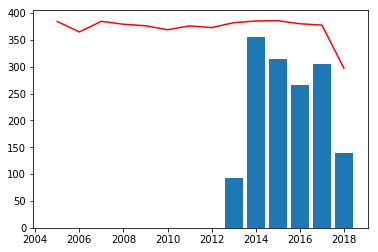

-------------------
Transit:  0412-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réfection CVCA et contrôles
Name: TypeProjet, dtype: object


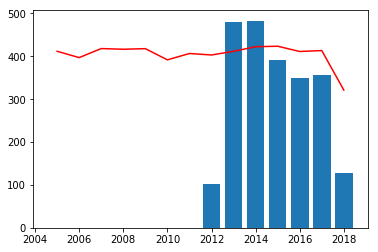

-------------------
Transit:  1026-1
Projet: 
Annee  ClasseProjet
2010   Mineur           Intégration Distech
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


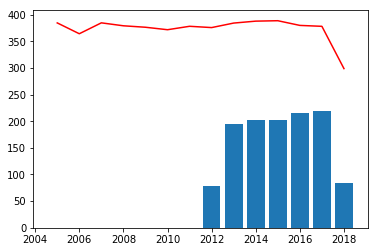

-------------------
Transit:  0014-1
Projet: 
Annee  ClasseProjet
2008   Mineur           Conversion de contrôles
2015   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


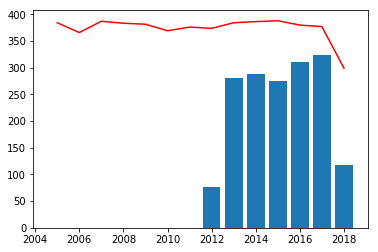

-------------------
Transit:  1015-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  1029-1
Projet: 
Annee  ClasseProjet
2008   Mineur          Conv. contrôles et éclair.
2015   Mineur                Réaménagement mineur
Name: TypeProjet, dtype: object


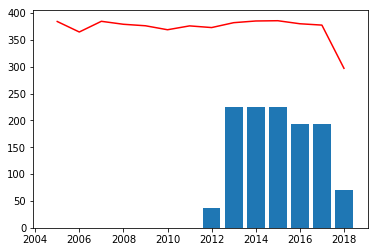

-------------------
Transit:  6599-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  0466-1
Projet: 
Annee  ClasseProjet
2012   Mineur             Conversion électrique
2010   Majeur                     Réaménagement
2015   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


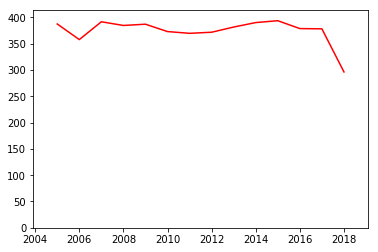

-------------------
Transit:  1228-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


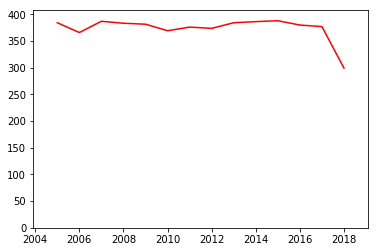

-------------------
Transit:  1187-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réfection CVCA et contrôles
2017   Majeur                   Majeur - Réduction
Name: TypeProjet, dtype: object


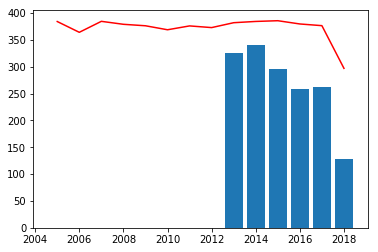

-------------------
Transit:  1169-1
Projet: 
Annee  ClasseProjet
2008   Mineur          Conv. contrôles et éclair.
2017   Mineur                  Améliorations CVCA
2015   Mineur                Réaménagement mineur
Name: TypeProjet, dtype: object


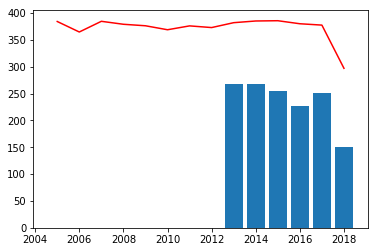

-------------------
Transit:  1315-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


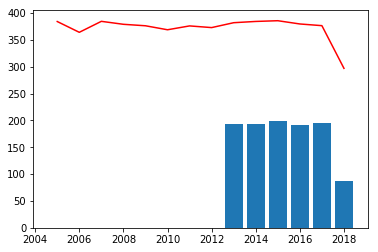

-------------------
Transit:  0107-1
Projet: 
Annee  ClasseProjet
2008   Mineur          Chaufferie et éclairage
2014   Mineur          Modernisation éclairage
2015   Mineur          Conversion de contrôles
2014   Mineur               Améliorations CVCA
Name: TypeProjet, dtype: object


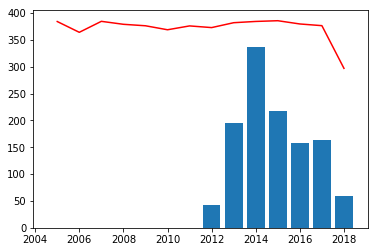

-------------------
Transit:  9159-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  0223-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Diagnostic énergétique
Name: TypeProjet, dtype: object


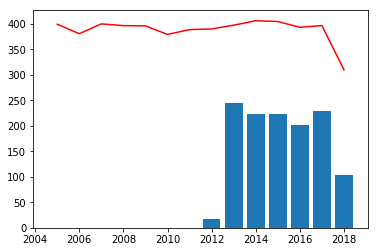

-------------------
Transit:  0687-1
Projet: 
Annee  ClasseProjet
2015   Mineur           Réfection CVCA et Ctrls
       Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


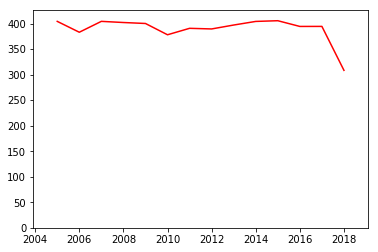

-------------------
Transit:  1421-1
Projet: 
Annee  ClasseProjet
2013   Majeur              Relocalisation
2015   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object


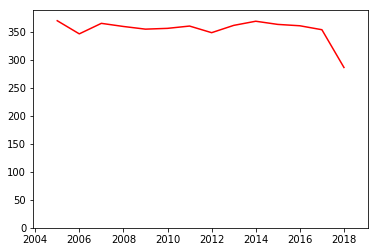

-------------------
Transit:  0259-1
Projet: 
Annee  ClasseProjet
2007   Mineur             Mise à niveau de contrôles
2015   Mineur          Optimisation contrôles exist.
Name: TypeProjet, dtype: object


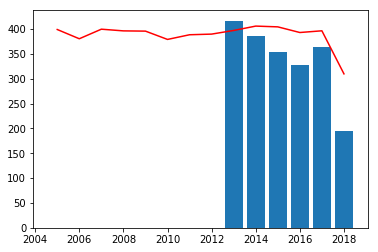

-------------------
Transit:  0154-1
Projet: 
Annee  ClasseProjet
2007   Mineur          Conv. contrôles et éclair.
2011   Mineur                      Agrandissement
2015   Mineur                  Améliorations CVCA
Name: TypeProjet, dtype: object


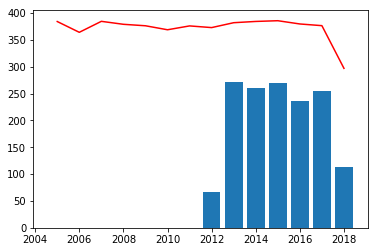

-------------------
Transit:  0173-1
Projet: 
Annee  ClasseProjet
2009   Mineur          Conversion de contrôles
2015   Mineur               Améliorations CVCA
2018   Mineur                  Diagnostic CVCA
Name: TypeProjet, dtype: object


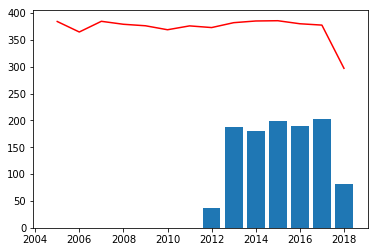

-------------------
Transit:  13-B-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Projet spécial
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  1166-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Optimisation contrôles exist.
2017   Majeur                 Majeur - Réaménagement
Name: TypeProjet, dtype: object


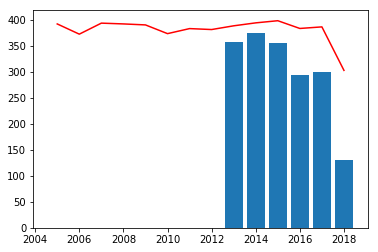

-------------------
Transit:  2341-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Expertise
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  1237-1
Projet: 
Annee  ClasseProjet
2014   Majeur                Relocalisation
       Majeur              Cx projet majeur
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


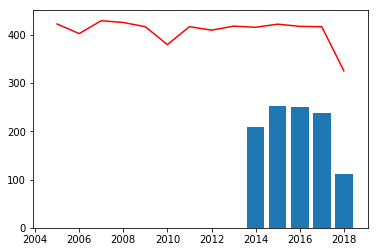

-------------------
Transit:  1178-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


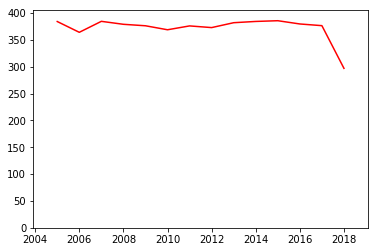

-------------------
Transit:  0464-1
Projet: 
Annee  ClasseProjet
2007   Mineur          Conv. contrôles et éclair.
2010   Mineur                      Agrandissement
2015   Mineur                  Améliorations CVCA
Name: TypeProjet, dtype: object


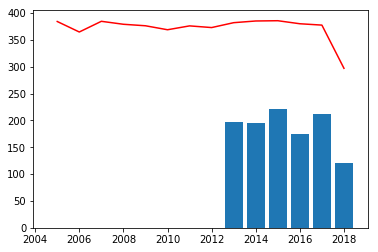

-------------------
Transit:  1013-1
Projet: 
Annee  ClasseProjet
2015   Mineur           Conversion de contrôles
2017   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


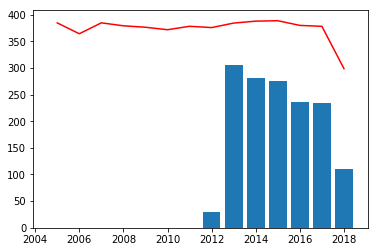

-------------------
Transit:  1041-1
Projet: 
Annee  ClasseProjet
2008   Mineur          Mise à niveau de contrôles
2015   Mineur             Conversion de contrôles
Name: TypeProjet, dtype: object


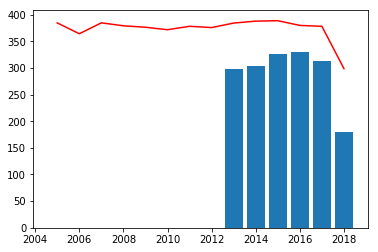

-------------------
Transit:  1314-1
Projet: 
Annee  ClasseProjet
2016   Majeur          Majeur - Reloc nouv. bât.
2015   Mineur                 Améliorations CVCA
Name: TypeProjet, dtype: object


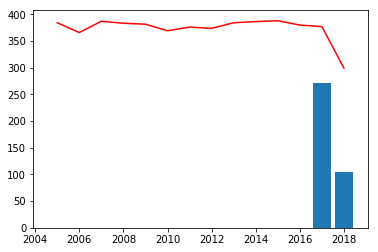

-------------------
Transit:  0772-1
Projet: 
Annee  ClasseProjet
2008   Mineur          Conv. contrôles et éclair.
2015   Mineur            Remplacement équip. CVCA
2016   Mineur                      Projet spécial
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  0047-1
Projet: 
Annee  ClasseProjet
2008   Mineur             Intégration Delta
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


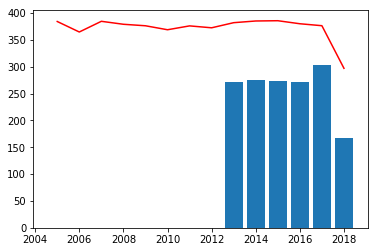

-------------------
Transit:  0171-1
Projet: 
Annee  ClasseProjet
2014   Mineur                     Expertise
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


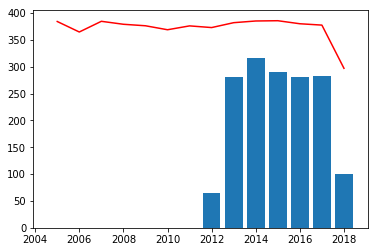

-------------------
Transit:  1108-1
Projet: 
Annee  ClasseProjet
2016   Majeur            Majeur - Réaménagement
2015   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


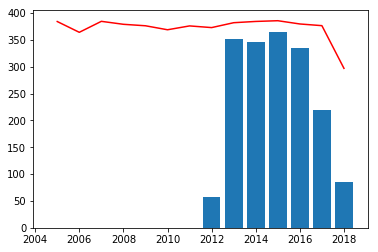

-------------------
Transit:  1152-1
Projet: 
Annee  ClasseProjet
2014   Mineur          Remplacement équip. CVCA
2015   Mineur                Améliorations CVCA
2017   Mineur                         Expertise
Name: TypeProjet, dtype: object


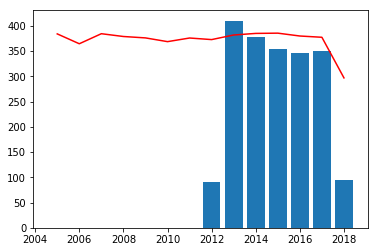

-------------------
Transit:  0200-1
Projet: 
Annee  ClasseProjet
2007   Mineur           Conversion de contrôles
2015   Mineur          Remplacement équip. CVCA
2018   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


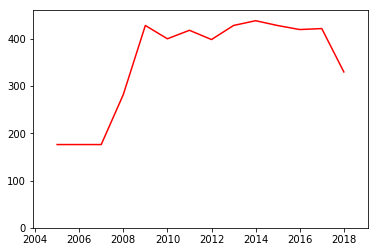

-------------------
Transit:  0159-1
Projet: 
Annee  ClasseProjet
2010   Mineur          Étanchéité et chaufferie
2012   Mineur           Réfection CVCA et Ctrls
2017   Majeur                Majeur - Réduction
2015   Mineur                Améliorations CVCA
Name: TypeProjet, dtype: object


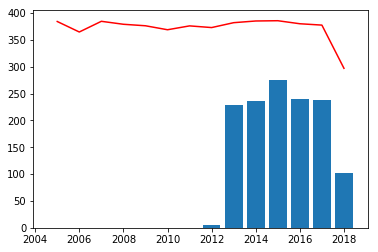

-------------------
Transit:  0461-1
Projet: 
Annee  ClasseProjet
2011   Majeur              Relocalisation
2015   Mineur          Améliorations CVCA
2018   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object


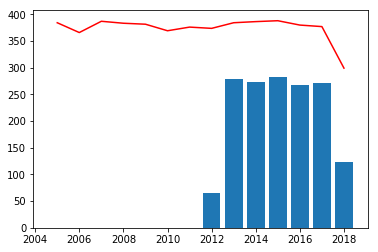

-------------------
Transit:  1133-1
Projet: 
Annee  ClasseProjet
2015   Mineur            Améliorations CVCA
       Mineur          Réaménagement mineur
2016   Mineur            Améliorations CVCA
Name: TypeProjet, dtype: object


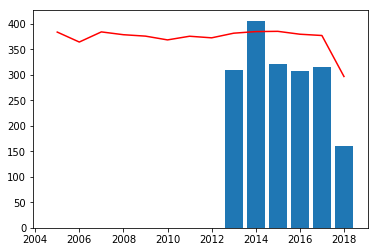

-------------------
Transit:  0070-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


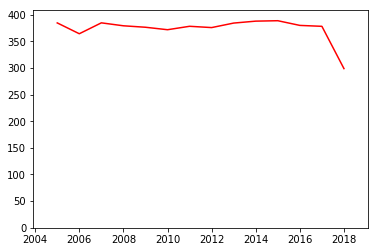

-------------------
Transit:  12-B-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Projet spécial
Name: TypeProjet, dtype: object
Pas de factures
-------------------
Transit:  1283-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


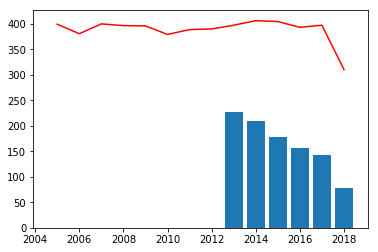

-------------------


In [25]:
listMajeurs = df_projets.xs('Majeur', level=2).index
listMineurs = df_projets.xs('Mineur', level=2).xs(2015, level=1).index
for i in listMajeurs:
    if i in listMineurs:
        listMineurs.remove(i)
        
for transit in set(listMineurs):
    print('Transit: ',transit)
    #print('Superficie (m2): ',df_succursales.loc[transit]['superficie_m2'])
    print('Projet: ')
    try:
        print(df_projets.loc[transit]['TypeProjet'])
        plt.plot(df_annee.loc[transit]['Consommation_norm_DJ'].index,
        df_annee.loc[transit]['Consommation_norm_DJ'],color='red')
        plt.bar(df_annee.loc[transit]['Consommation_kWh_eq_m2'].index,
        df_annee.loc[transit]['Consommation_kWh_eq_m2'])
        plt.show()
        print('-------------------')
    except:
        print('Pas de factures')
        print('-------------------')

Transit:  1188-1
Projet: 
Annee  ClasseProjet
2013   Majeur              Relocalisation
2015   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object


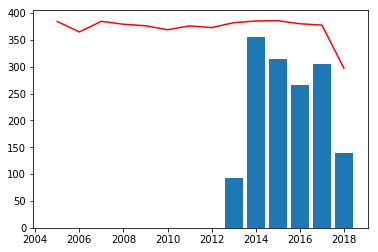

-------------------
Transit:  0412-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Réfection CVCA et contrôles
Name: TypeProjet, dtype: object


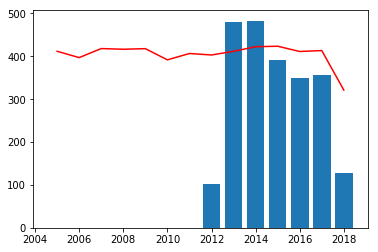

-------------------
Transit:  1026-1
Projet: 
Annee  ClasseProjet
2010   Mineur           Intégration Distech
2015   Mineur          Réaménagement mineur
Name: TypeProjet, dtype: object


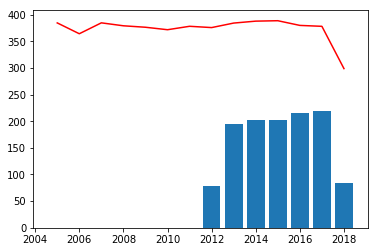

-------------------
Transit:  0014-1
Projet: 
Annee  ClasseProjet
2008   Mineur           Conversion de contrôles
2015   Mineur          Remplacement équip. CVCA
Name: TypeProjet, dtype: object


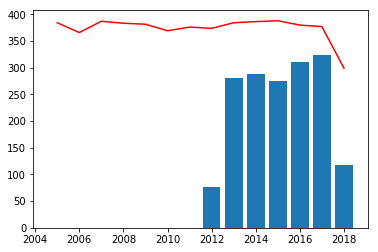

-------------------
Transit:  1015-1
Projet: 
Annee  ClasseProjet
2015   Mineur          Améliorations CVCA
Name: TypeProjet, dtype: object


KeyError: 'the label [1015-1] is not in the [index]'

In [20]:
listMajeurs = df_projets.xs('Majeur', level=2).index
listMineurs = df_projets.xs('Mineur', level=2).xs(2015, level=1).index

for transit in listMajeurs:
    print('Transit: ',transit)
    #print('Superficie (m2): ',df_succursales.loc[transit]['superficie_m2'])
    print('Projet: ')
    try:
        print(df_projets.loc[transit]['TypeProjet'])
        plt.plot(df_annee.loc[transit]['Consommation_norm_DJ'].index,
        df_annee.loc[transit]['Consommation_norm_DJ'],color='red')
        plt.bar(df_annee.loc[transit]['Consommation_kWh_eq_m2'].index,
        df_annee.loc[transit]['Consommation_kWh_eq_m2'])
        plt.show()
        print('-------------------')
    except:
        print('Pas de factures')
        print('-------------------')

In [ ]:
df_annee['Consommation_kWh_eq_m2_pct_change'] = df_annee['Consommation_kWh_eq_m2'].pct_change()
df_annee['Consommation_norm_DJ_pct_change'] = df_annee['Consommation_norm_DJ'].pct_change()

In [ ]:
df_DJ.xs(('0001-1', 2005), level=[0, 1]).sum()

In [ ]:
df_projets.xs('Majeur', level=2)
df_projets.xs('Mineur', level=2).xs(2015, level=1)

In [ ]:
df_projets.xs('Mineur', level=2).xs(2015, level=1).index

In [46]:
listMajeurs = df_projets.xs('Majeur', level=2).index.get_level_values(0).tolist()
listMineurs = df_projets.xs('Mineur', level=2).index.get_level_values(0).tolist()
for i in listMajeurs:
    if i in listMineurs:
        print(i)
        listMineurs.remove(i)

0120-1
0284-1
0401-1
0499-1
1253-1
1360-1
0030-1
0403-1
0038-1
0066-1
0130-1
0271-1
0427-1
0635-1
0777-1
1027-1
1085-1
0110-1
0158-1
0244-1
0466-1
1379-1
0028-1
0150-1
0177-1
0267-1
0322-1
0416-1
0461-1
0870-1
1084-1
1358-1
1064-1
1161-1
0050-1
0182-1
1188-1
1373-1
1421-1
1237-1
1203-1
0443-1
0235-1
1108-1
1109-1
0503-1
0159-1
1314-1
0231-1
1177-1
1327-1
0276-1
1032-1
0201-1
7147-1
1187-1
1166-1
1385-1


In [45]:
df_projets.xs('Majeur', level=2).index.get_level_values(0).tolist

<bound method IndexOpsMixin.tolist of Index(['0759-1', '0098-1', '0120-1', '0205-1', '0284-1', '0401-1', '0499-1',
       '0601-1', '0673-1', '1126-1',
       ...
       '0428-1', '1075-1', '1322-1', '1166-1', '1080-1', '1042-1', '1385-1',
       '0624-1', '0311-1', '0324-1'],
      dtype='object', name='Transit', length=170)>